In [ ]:
!pip install pytorch-accelerated

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
!pip install ipywidgets

In [ ]:
## nnAudio
!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

In [ ]:
!pip install timm

In [ ]:
!pip install torchmetrics

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import config
from glob import glob

from tqdm.notebook import tqdm

import random
import math
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from pytorch_accelerated import Trainer

import timm

import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from nnAudio import features

from timm.loss import LabelSmoothingCrossEntropy
import timm.optim

from torchmetrics import MetricCollection, Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score

from evaluate_torch import get_results, evaluate_model_timestamp

# Evaluation with PSDS
from eval import do_eval 

INFO:pytorch_accelerated:Setting random seeds


In [2]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [3]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [4]:
def evaluate_model(model, test_loader, n_samples, n_channels=3):
    with torch.no_grad():
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f'Evaluating on {device}')

        softmax = nn.Softmax(dim=1)
        
        y_preds_all = torch.zeros([n_samples, len(test_loader.dataset), 2])
        model.eval() # Important to not leak info from batch norm layers and cause other issues
        
        for n in range(n_samples):
            all_y_pred = []
            all_y = []
            for x, y, idx in tqdm(test_loader):
                x, y = x.to(device), y.to(device)

                y_pred = model(x)['prediction']
                all_y.append(y.cpu().detach())

                all_y_pred.append(y_pred.cpu().detach())

                del x
                del y
                del y_pred

            all_y_pred = torch.cat(all_y_pred)
            all_y = torch.cat(all_y)

            y_preds_all[n,:] = softmax(all_y_pred)
#             y_preds_all[n,:,1] = np.array(sigmoid(all_y_pred).squeeze())
#             y_preds_all[n,:,0] = 1-np.array(sigmoid(all_y_pred).squeeze()) # Check ordering of classes (yes/no)
            test_acc = accuracy_score(all_y.numpy(), torch.argmax(all_y_pred,dim=1).numpy())
            print(test_acc)
    return y_preds_all, all_y

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [110]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.3, global_pool='avgmax',
                        drop_rate=0.3)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
#         for name, param in self.backbone.named_parameters():
#             if param.requires_grad and 'head' not in name \
#                 and not name.startswith('norm') \
#                 and 'stages.3' not in name and 'layers.3' not in name \
#                 and 'blocks.26' not in name and 'blocks.26' not in name \
#                 and 'blocks.24' not in name and 'blocks.25' not in name \
#                 and 'blocks.22' not in name and 'blocks.23' not in name \
#                 and 'blocks.20' not in name and 'blocks.21' not in name \
#                 and 'blocks.22' not in name and 'blocks.23' not in name \
#                 and 'blocks.19' not in name and 'blocks.18' not in name \
#                 and 'blocks.17' not in name and 'blocks.5.' not in name:
#                 param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=2048, freq_bins=None, hop_length=512,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300,fmax = 1100 ,sr=8000, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.median_filter = MedianPool2d()
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        #print("spec shape after applying STFT = " + str(spec.shape))
        
              
        spec = self.median_filter(spec)
        #print("spec shape after median filter = " + str(spec.shape))
        spec_squee = torch.squeeze(spec)
        #print("Post squeeze spec shape = " + str(spec_squee.shape))
        
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
#         spec = self.pcen_layer(spec_squee)
        #print("Post PCEN shape = " + str(spec.device))
        spec = self.norm_layer(spec)
        #print("Post norm shape = " + str(spec.shape))
        if self.training:
            spec = self.timeMasking(spec)
            #print("Post time masking shape = " + str(spec.shape))
        
            spec = self.freqMasking(spec)
            #print("Post freq masking shape = " + str(spec.shape))

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        #print("Post sizer device = " + str(spec.device))
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        #print("PRED device = " + str(pred.device))
        
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [15]:
# mids capstone
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=2, in_chans=1, 
                        drop_path_rate=0.1, global_pool='avgmax',
                        drop_rate=0.1)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
        for name, param in self.backbone.named_parameters():
            if param.requires_grad and 'head' not in name \
                and not name.startswith('norm') \
                and 'stages.3' not in name and 'layers.3' not in name \
                and 'blocks.26' not in name and 'blocks.26' not in name \
                and 'blocks.24' not in name and 'blocks.25' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.20' not in name and 'blocks.21' not in name \
                and 'blocks.22' not in name and 'blocks.23' not in name \
                and 'blocks.19' not in name and 'blocks.18' not in name \
                and 'blocks.17' not in name and 'blocks.5.' not in name:
                param.requires_grad = False
        #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='log2', center=True, pad_mode='reflect',
                          fmin=300, fmax=3000, sr=config.rate, output_format="Magnitude", trainable=True)
#         self.spec_layer = features.MelSpectrogram(n_fft=config.NFFT, n_mels=128, hop_length=config.n_hop,
#                                 window='hann',  center=True, pad_mode='reflect',
#                           sr=config.rate,  trainable_mel=True, trainable_STFT=True)
#         self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = AT.TimeMasking(time_mask_param=30, iid_masks=True)
        self.freqMasking = AT.FrequencyMasking(freq_mask_param=20, iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
#             spec = self.timeMasking(spec)
#             spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        pred = self.backbone(x)
        
#        pred = self.out(x)
        
        output = {"prediction": pred,
                  "spectrogram": spec}
        return output

In [24]:
# optional, save model
torch.save(model.state_dict(), '../models/VecNet_2020_06_06')

In [2]:
config.NFFT = 1024
config.win_size = 360
config.n_hop = config.NFFT//8
config.step_size = config.win_size//3

In [7]:
# optional, load model
model = Model('convnext_base_384_in22ft1k',384)
# model.load_state_dict(torch.load('../models/model_e0_2022_06_05_18_21_52.pth'))
# model.load_state_dict(torch.load('../models/NoMasking_model_e0_2022_06_14_14_31_40.pth'))
model.load_state_dict(torch.load('../models/model_e13_2022_06_16_19_30_56.pth'))
# model.load_state_dict(torch.load('../models/model_e1_2022_04_07_11_52_08.pth'))
model.eval()

INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0670 seconds


Model(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), 

In [12]:
cp ../../HumBugDB/outputs/models/pytorch/model_e18_2022_06_22_03_00_16.pth ../models/

In [98]:
model_name = 'NoPCENmodel_e2_2022_06_14_18_14_22'
# model_name = 'model_e2_2022_06_18_22_03_19.pth'

In [99]:
feat_type='NoPCENmodel_e2_2022_06_14_18_14_22'
# feat_type='model_e0_2022_06_06_04_27_53'

In [91]:
# Evaluate over dev A

In [92]:
# clear old predictions if necessary
!rm -rf ../data/predictions/dev/a
!mkdir ../data/predictions/dev/a

In [93]:
# Evaluate over dev A
evaluate_model_timestamp('.wav','../data/audio/dev/a','../data/predictions/dev/a', 2, 
                         model_weights_path=f'../models/{model_name}.pth',
                         win_size=config.win_size, step_size=config.step_size, n_hop=config.n_hop, debug=True)

Evaluating model:


INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0641 seconds
Loaded model: ../models/WithoutMusan_model_e0_2022_06_14_03_25_05.pth
Processing: ../data/audio/dev/a for audio format: .wav
../data/audio/dev/a 208049.wav
208049.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208049.wav
[[0.0, 2.56, '0.4860 PE: 0.9745 MI: 0.2622']]
[[0.0, 2.56, '0.4860 PE: 0.9745 MI: 0.2622']]
[[0.0, 2.56, '0.4860 PE: 0.9745 MI: 0.2622']]
[[0.64, 2.56, '0.5303 PE: 0.9871 MI: 0.3180']]
[[0.64, 1.92, '0.5712 PE: 0.9844 MI: 0.2911']]
[]
[]
[]
[]
[]
Processed: 208049.wav
../data/audio/dev/a 207925.wav
207925.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207925.wav
[[0.0, 1.92, '0.8877 PE: 0.4514 MI: 0.0952']]
[[0.0, 1.92, '0.8877 PE: 0.4514 MI: 0.0952']]
[[0.0, 1.92, '0.8877 PE: 0.4514 MI: 0.0952']]
[[0.0, 1.92, '0.8877 PE: 0.4514 MI: 0.0952']]
[[0.0, 1.92, '0.8877 PE: 0.

dir_out ../data/predictions/dev/a filename 207853.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207853.wav
../data/audio/dev/a 207967.wav
207967.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207967.wav
[[0.0, 1.28, '0.1073 PE: 0.4916 MI: 0.0158']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207967.wav
../data/audio/dev/a 207903.wav
207903.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207903.wav
[[0.0, 1.92, '0.1458 PE: 0.5948 MI: 0.0064']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207903.wav
../data/audio/dev/a 208482.wav
208482.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208482.wav
[[0.0, 2.56, '0.8420 PE: 0.5208 MI: 0.1260']]
[[0.0, 2.56, '0.8420 PE: 0.5208 MI: 0.1260']]
[[0.0, 2.56, '0.8420 PE: 0.5208 MI: 0.1260']]
[[0.0, 2.56, '0.8420 PE: 0.5208 MI: 0.1260']]
[[0.0, 2.56, '0.8420 PE: 0.5208 MI: 0.1260']]
[[0.0, 1.92, '0.9256 PE: 0.3692 MI: 0.0242']]
[[0.0, 1.92, '0.9256 PE: 0.3692 MI: 0.0242']]
[[0.0, 1.92, '

dir_out ../data/predictions/dev/a filename 207012.wav
[[0.0, 12.16, '0.9315 PE: 0.3267 MI: 0.0266']]
[[0.0, 12.16, '0.9315 PE: 0.3267 MI: 0.0266']]
[[0.0, 12.16, '0.9315 PE: 0.3267 MI: 0.0266']]
[[0.0, 12.16, '0.9315 PE: 0.3267 MI: 0.0266']]
[[0.0, 12.16, '0.9315 PE: 0.3267 MI: 0.0266']]
[[0.0, 12.16, '0.9315 PE: 0.3267 MI: 0.0266']]
[[0.0, 11.52, '0.9484 PE: 0.2920 MI: 0.0013']]
[[0.0, 11.52, '0.9484 PE: 0.2920 MI: 0.0013']]
[[0.0, 11.52, '0.9484 PE: 0.2920 MI: 0.0013']]
[]
Processed: 207012.wav
../data/audio/dev/a 207358.wav
207358.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207358.wav
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0, 1.92, '0.9491 PE: 0.2901 MI: 0.0011']]
[[0.0,

dir_out ../data/predictions/dev/a filename 208391.wav
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[[0.0, 4.48, '0.9521 PE: 0.2772 MI: 0.0002']]
[]
Processed: 208391.wav
../data/audio/dev/a 207146.wav
207146.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207146.wav
[[0.0, 2.56, '0.7687 PE: 0.6836 MI: 0.2824']]
[[0.0, 2.56, '0.7687 PE: 0.6836 MI: 0.2824']]
[[0.0, 2.56, '0.7687 PE: 0.6836 MI: 0.2824']]
[[0.0, 2.56, '0.7687 PE: 0.6836 MI: 0.2824']]
[[0.0, 2.56, '0.7687 PE: 0.6836 MI: 0.2824']]
[[0.64, 2.56, '0.8262 PE: 0.5872 MI: 0.2184']]
[[0.64, 1.92, '0.9141 PE: 0.4138 MI: 0.0264']]
[[0.64, 1.92, '0.9141 PE: 0.4138 MI: 0.0264']]
[[1.28, 1.92, '0

dir_out ../data/predictions/dev/a filename 208087.wav
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.0, 1.92, '0.9331 PE: 0.3482 MI: 0.0126']]
[[0.64, 1.92, '0.9499 PE: 0.2870 MI: 0.0002']]
[]
Processed: 208087.wav
../data/audio/dev/a 207828.wav
207828.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207828.wav
[[0.0, 4.48, '0.7128 PE: 0.6625 MI: 0.3068']]
[[0.0, 4.48, '0.7128 PE: 0.6625 MI: 0.3068']]
[[0.0, 4.48, '0.7128 PE: 0.6625 MI: 0.3068']]
[[0.0, 3.84, '0.7680 PE: 0.6131 MI: 0.2640']]
[[0.64, 3.84, '0.8370 PE: 0.5392 MI: 0.2237']]
[[0.64, 3.84, '0.8370 PE: 0.5392 MI: 0.2237']]
[[1.28, 3.2, '0.9498 PE: 0.2873 MI: 0.0001']]
[[1.28, 3.2, '0.9498 PE: 0.2873 MI: 0.0001']]
[[1.28, 3.2, '0.

dir_out ../data/predictions/dev/a filename 208448.wav
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[[0.0, 2.56, '0.9306 PE: 0.3626 MI: 0.0037']]
[]
Processed: 208448.wav
../data/audio/dev/a 208689.wav
208689.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208689.wav
[[0.0, 2.56, '0.8210 PE: 0.5863 MI: 0.2417']]
[[0.0, 2.56, '0.8210 PE: 0.5863 MI: 0.2417']]
[[0.0, 2.56, '0.8210 PE: 0.5863 MI: 0.2417']]
[[0.0, 2.56, '0.8210 PE: 0.5863 MI: 0.2417']]
[[0.0, 2.56, '0.8210 PE: 0.5863 MI: 0.2417']]
[[0.0, 2.56, '0.8210 PE: 0.5863 MI: 0.2417']]
[[0.0, 1.92, '0.8756 PE: 0.4726 MI: 0.1254']]
[[0.64, 1.92, '0.9501 PE: 0.2857 MI: 0.0005']]
[[0.64, 1.92, '0.9

dir_out ../data/predictions/dev/a filename 207149.wav
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.92, '0.9111 PE: 0.4107 MI: 0.0449']]
[[0.0, 1.28, '0.9475 PE: 0.2968 MI: 0.0004']]
[]
Processed: 207149.wav
../data/audio/dev/a 206706.wav
206706.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206706.wav
[[0.0, 2.56, '0.7726 PE: 0.6989 MI: 0.2209']]
[[0.0, 2.56, '0.7726 PE: 0.6989 MI: 0.2209']]
[[0.0, 2.56, '0.7726 PE: 0.6989 MI: 0.2209']]
[[0.0, 2.56, '0.7726 PE: 0.6989 MI: 0.2209']]
[[0.0, 2.56, '0.7726 PE: 0.6989 MI: 0.2209']]
[[0.0, 2.56, '0.7726 PE: 0.6989 MI: 0.2209']]
[[0.64, 1.92, '0.8948 PE: 0.4650 MI: 0.0558']]
[[0.64, 1.92, '0.8948 PE: 0.4650 MI: 0.0558']]
[[1.28, 1.92, '0.

dir_out ../data/predictions/dev/a filename 208183.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208183.wav
../data/audio/dev/a 206669.wav
206669.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206669.wav
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.0, 2.56, '0.8871 PE: 0.4369 MI: 0.1009']]
[[0.64, 2.56, '0.9493 PE: 0.2890 MI: 0.0010']]
[[0.64, 2.56, '0.9493 PE: 0.2890 MI: 0.0010']]
[]
Processed: 206669.wav
../data/audio/dev/a 207269.wav
207269.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207269.wav
[[0.64, 3.2, '0.1116 PE: 0.5044 MI: 0.0017']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207269.wav
../data/audio/dev/a 207921.wav
207921.wav signal length 12.8 1.92
dir_out ../data/predictions/dev/a filename 207921.wa

dir_out ../data/predictions/dev/a filename 207802.wav
[[0.0, 5.12, '0.9119 PE: 0.3678 MI: 0.0721']]
[[0.0, 5.12, '0.9119 PE: 0.3678 MI: 0.0721']]
[[0.0, 5.12, '0.9119 PE: 0.3678 MI: 0.0721']]
[[0.0, 5.12, '0.9119 PE: 0.3678 MI: 0.0721']]
[[0.0, 5.12, '0.9119 PE: 0.3678 MI: 0.0721']]
[[0.0, 5.12, '0.9119 PE: 0.3678 MI: 0.0721']]
[[0.0, 4.48, '0.9499 PE: 0.2865 MI: 0.0007']]
[[0.0, 4.48, '0.9499 PE: 0.2865 MI: 0.0007']]
[[0.0, 4.48, '0.9499 PE: 0.2865 MI: 0.0007']]
[]
Processed: 207802.wav
../data/audio/dev/a 207685.wav
207685.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207685.wav
[[0.0, 2.56, '0.6496 PE: 0.8085 MI: 0.1958']]
[[0.0, 2.56, '0.6496 PE: 0.8085 MI: 0.1958']]
[[0.0, 2.56, '0.6496 PE: 0.8085 MI: 0.1958']]
[[0.64, 2.56, '0.7478 PE: 0.7652 MI: 0.1689']]
[[0.64, 2.56, '0.7478 PE: 0.7652 MI: 0.1689']]
[[1.28, 2.56, '0.8296 PE: 0.6580 MI: 0.0333']]
[[1.28, 2.56, '0.8296 PE: 0.6580 MI: 0.0333']]
[[1.28, 2.56, '0.8296 PE: 0.6580 MI: 0.0333']]
[]
[]
Processe

dir_out ../data/predictions/dev/a filename 208694.wav
[[0.0, 7.04, '0.8687 PE: 0.4642 MI: 0.1174']]
[[0.0, 7.04, '0.8687 PE: 0.4642 MI: 0.1174']]
[[0.0, 7.04, '0.8687 PE: 0.4642 MI: 0.1174']]
[[0.0, 7.04, '0.8687 PE: 0.4642 MI: 0.1174']]
[[0.0, 7.04, '0.8687 PE: 0.4642 MI: 0.1174']]
[[0.0, 7.04, '0.8687 PE: 0.4642 MI: 0.1174']]
[[1.28, 6.4, '0.9485 PE: 0.2913 MI: 0.0024']]
[[1.28, 6.4, '0.9485 PE: 0.2913 MI: 0.0024']]
[[1.28, 6.4, '0.9485 PE: 0.2913 MI: 0.0024']]
[]
Processed: 208694.wav
../data/audio/dev/a 206573.wav
206573.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206573.wav
[[0.0, 1.92, '0.6752 PE: 0.7785 MI: 0.3252']]
[[0.0, 1.92, '0.6752 PE: 0.7785 MI: 0.3252']]
[[0.0, 1.92, '0.6752 PE: 0.7785 MI: 0.3252']]
[[0.0, 1.92, '0.6752 PE: 0.7785 MI: 0.3252']]
[[0.64, 1.92, '0.8020 PE: 0.6767 MI: 0.2425']]
[[0.64, 1.92, '0.8020 PE: 0.6767 MI: 0.2425']]
[[0.64, 1.92, '0.8020 PE: 0.6767 MI: 0.2425']]
[[1.28, 1.92, '0.8957 PE: 0.4826 MI: 0.0480']]
[]
[]
Proce

dir_out ../data/predictions/dev/a filename 208701.wav
[[0.0, 2.56, '0.7938 PE: 0.6363 MI: 0.2767']]
[[0.0, 2.56, '0.7938 PE: 0.6363 MI: 0.2767']]
[[0.0, 2.56, '0.7938 PE: 0.6363 MI: 0.2767']]
[[0.0, 2.56, '0.7938 PE: 0.6363 MI: 0.2767']]
[[0.0, 2.56, '0.7938 PE: 0.6363 MI: 0.2767']]
[[0.0, 2.56, '0.7938 PE: 0.6363 MI: 0.2767']]
[[0.64, 1.92, '0.9368 PE: 0.3395 MI: 0.0040']]
[[0.64, 1.92, '0.9368 PE: 0.3395 MI: 0.0040']]
[[0.64, 1.92, '0.9368 PE: 0.3395 MI: 0.0040']]
[]
Processed: 208701.wav
../data/audio/dev/a 208220.wav
208220.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208220.wav
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92, '0.9512 PE: 0.2813 MI: 0.0002']]
[[0.0, 1.92,

dir_out ../data/predictions/dev/a filename 208065.wav
[[0.0, 2.56, '0.7484 PE: 0.6127 MI: 0.2434']]
[[0.0, 2.56, '0.7484 PE: 0.6127 MI: 0.2434']]
[[0.0, 2.56, '0.7484 PE: 0.6127 MI: 0.2434']]
[[0.0, 2.56, '0.7484 PE: 0.6127 MI: 0.2434']]
[[0.0, 1.92, '0.8635 PE: 0.4926 MI: 0.1541']]
[[0.0, 1.92, '0.8635 PE: 0.4926 MI: 0.1541']]
[[0.0, 1.28, '0.9480 PE: 0.2950 MI: 0.0001']]
[[0.0, 1.28, '0.9480 PE: 0.2950 MI: 0.0001']]
[[0.0, 1.28, '0.9480 PE: 0.2950 MI: 0.0001']]
[]
Processed: 208065.wav
../data/audio/dev/a 207425.wav
207425.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207425.wav
[[0.0, 5.12, '0.5647 PE: 0.6772 MI: 0.2084']]
[[0.0, 3.84, '0.7049 PE: 0.7052 MI: 0.2759']]
[[0.0, 3.84, '0.7049 PE: 0.7052 MI: 0.2759']]
[[0.0, 3.2, '0.7690 PE: 0.6539 MI: 0.2345']]
[[0.0, 3.2, '0.7690 PE: 0.6539 MI: 0.2345']]
[[0.64, 3.2, '0.8360 PE: 0.5674 MI: 0.1875']]
[[0.64, 2.56, '0.8932 PE: 0.4497 MI: 0.0777']]
[[1.28, 2.56, '0.9466 PE: 0.3004 MI: 0.0013']]
[[1.28, 2.56, '0.94

dir_out ../data/predictions/dev/a filename 206595.wav
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.0, 2.56, '0.8888 PE: 0.4520 MI: 0.0664']]
[[0.64, 2.56, '0.9407 PE: 0.3237 MI: 0.0033']]
[[0.64, 2.56, '0.9407 PE: 0.3237 MI: 0.0033']]
[]
Processed: 206595.wav
../data/audio/dev/a 206644.wav
206644.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206644.wav
[[0.0, 2.56, '0.7391 PE: 0.6237 MI: 0.2460']]
[[0.0, 2.56, '0.7391 PE: 0.6237 MI: 0.2460']]
[[0.0, 2.56, '0.7391 PE: 0.6237 MI: 0.2460']]
[[0.0, 1.92, '0.8558 PE: 0.5103 MI: 0.1625']]
[[0.0, 1.92, '0.8558 PE: 0.5103 MI: 0.1625']]
[[0.0, 1.92, '0.8558 PE: 0.5103 MI: 0.1625']]
[[0.0, 1.28, '0.9435 PE: 0.3135 MI: 0.0031']]
[[0.0, 1.28, '0.9435 PE: 0.3135 MI: 0.0031']]
[[0.0, 1.28, '0.9

dir_out ../data/predictions/dev/a filename 207088.wav
[[0.0, 1.92, '0.7090 PE: 0.7225 MI: 0.2522']]
[[0.0, 1.92, '0.7090 PE: 0.7225 MI: 0.2522']]
[[0.0, 1.92, '0.7090 PE: 0.7225 MI: 0.2522']]
[[0.0, 1.92, '0.7090 PE: 0.7225 MI: 0.2522']]
[[0.0, 1.28, '0.8360 PE: 0.5866 MI: 0.1617']]
[[0.0, 1.28, '0.8360 PE: 0.5866 MI: 0.1617']]
[[0.0, 1.28, '0.8360 PE: 0.5866 MI: 0.1617']]
[[0.0, 0.64, '0.9371 PE: 0.3388 MI: 0.0008']]
[[0.0, 0.64, '0.9371 PE: 0.3388 MI: 0.0008']]
[]
Processed: 207088.wav
../data/audio/dev/a 207043.wav
207043.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207043.wav
[[0.0, 1.92, '0.8401 PE: 0.5412 MI: 0.1555']]
[[0.0, 1.92, '0.8401 PE: 0.5412 MI: 0.1555']]
[[0.0, 1.92, '0.8401 PE: 0.5412 MI: 0.1555']]
[[0.0, 1.92, '0.8401 PE: 0.5412 MI: 0.1555']]
[[0.0, 1.92, '0.8401 PE: 0.5412 MI: 0.1555']]
[[0.0, 1.92, '0.8401 PE: 0.5412 MI: 0.1555']]
[[0.0, 1.28, '0.9349 PE: 0.3450 MI: 0.0101']]
[[0.0, 1.28, '0.9349 PE: 0.3450 MI: 0.0101']]
[[0.0, 1.28, '0

dir_out ../data/predictions/dev/a filename 208599.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208599.wav
../data/audio/dev/a 207087.wav
207087.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207087.wav
[[0.0, 1.92, '0.8583 PE: 0.4934 MI: 0.1734']]
[[0.0, 1.92, '0.8583 PE: 0.4934 MI: 0.1734']]
[[0.0, 1.92, '0.8583 PE: 0.4934 MI: 0.1734']]
[[0.0, 1.92, '0.8583 PE: 0.4934 MI: 0.1734']]
[[0.0, 1.92, '0.8583 PE: 0.4934 MI: 0.1734']]
[[0.0, 1.92, '0.8583 PE: 0.4934 MI: 0.1734']]
[[0.64, 1.92, '0.9504 PE: 0.2848 MI: 0.0003']]
[[0.64, 1.92, '0.9504 PE: 0.2848 MI: 0.0003']]
[[0.64, 1.92, '0.9504 PE: 0.2848 MI: 0.0003']]
[]
Processed: 207087.wav
../data/audio/dev/a 207782.wav
207782.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207782.wav
[[0.0, 2.56, '0.8350 PE: 0.5742 MI: 0.1845']]
[[0.0, 2.56, '0.8350 PE: 0.5742 MI: 0.1845']]
[[0.0, 2.56, '0.8350 PE: 0.5742 MI: 0.1845']]
[[0.0, 2.56, '0.8350 PE: 0.5742 MI: 0.1845']]
[[0.0, 2.56, '0.8350 PE:

dir_out ../data/predictions/dev/a filename 207544.wav
[[0.0, 1.92, '0.8503 PE: 0.5023 MI: 0.2103']]
[[0.0, 1.92, '0.8503 PE: 0.5023 MI: 0.2103']]
[[0.0, 1.92, '0.8503 PE: 0.5023 MI: 0.2103']]
[[0.0, 1.92, '0.8503 PE: 0.5023 MI: 0.2103']]
[[0.0, 1.92, '0.8503 PE: 0.5023 MI: 0.2103']]
[[0.0, 1.92, '0.8503 PE: 0.5023 MI: 0.2103']]
[[0.0, 1.28, '0.9498 PE: 0.2871 MI: 0.0001']]
[[0.0, 1.28, '0.9498 PE: 0.2871 MI: 0.0001']]
[[0.0, 1.28, '0.9498 PE: 0.2871 MI: 0.0001']]
[]
Processed: 207544.wav
../data/audio/dev/a 208590.wav
208590.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208590.wav
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0.9509 PE: 0.2827 MI: 0.0003']]
[[0.0, 4.48, '0

dir_out ../data/predictions/dev/a filename 207144.wav
[[0.0, 7.68, '0.6887 PE: 0.6541 MI: 0.2569']]
[[0.0, 7.04, '0.7336 PE: 0.6488 MI: 0.2692']]
[[0.0, 7.04, '0.7336 PE: 0.6488 MI: 0.2692']]
[[0.0, 2.56, '0.8686 PE: 0.4910 MI: 0.1404'], [3.84, 7.04, '0.7637 PE: 0.6491 MI: 0.2664']]
[[0.0, 2.56, '0.8686 PE: 0.4910 MI: 0.1404'], [3.84, 6.4, '0.8347 PE: 0.5617 MI: 0.2159']]
[[0.0, 2.56, '0.8686 PE: 0.4910 MI: 0.1404'], [3.84, 6.4, '0.8347 PE: 0.5617 MI: 0.2159']]
[[0.0, 1.92, '0.9306 PE: 0.3542 MI: 0.0185'], [4.48, 6.4, '0.8941 PE: 0.4395 MI: 0.0843']]
[[0.0, 1.92, '0.9306 PE: 0.3542 MI: 0.0185'], [4.48, 5.76, '0.9521 PE: 0.2775 MI: 0.0002']]
[[0.64, 1.92, '0.9517 PE: 0.2789 MI: 0.0002'], [4.48, 5.76, '0.9521 PE: 0.2775 MI: 0.0002']]
[]
Processed: 207144.wav
../data/audio/dev/a 208691.wav
208691.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208691.wav
[[0.0, 2.56, '0.9036 PE: 0.4138 MI: 0.0712']]
[[0.0, 2.56, '0.9036 PE: 0.4138 MI: 0.0712']]
[[0.0, 2.56, '0.9036 

dir_out ../data/predictions/dev/a filename 208039.wav
[[0.0, 4.48, '0.9109 PE: 0.3673 MI: 0.0855']]
[[0.0, 4.48, '0.9109 PE: 0.3673 MI: 0.0855']]
[[0.0, 4.48, '0.9109 PE: 0.3673 MI: 0.0855']]
[[0.0, 4.48, '0.9109 PE: 0.3673 MI: 0.0855']]
[[0.0, 4.48, '0.9109 PE: 0.3673 MI: 0.0855']]
[[0.0, 4.48, '0.9109 PE: 0.3673 MI: 0.0855']]
[[0.64, 4.48, '0.9528 PE: 0.2743 MI: 0.0001']]
[[0.64, 4.48, '0.9528 PE: 0.2743 MI: 0.0001']]
[[0.64, 4.48, '0.9528 PE: 0.2743 MI: 0.0001']]
[]
Processed: 208039.wav
../data/audio/dev/a 206829.wav
206829.wav signal length 12.799875 1.92
dir_out ../data/predictions/dev/a filename 206829.wav
[[3.84, 4.48, '0.1004 PE: 0.4701 MI: 0.0007'], [7.04, 8.96, '0.1386 PE: 0.5802 MI: 0.0088']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206829.wav
../data/audio/dev/a 206923.wav
206923.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206923.wav
[[0.0, 1.92, '0.9494 PE: 0.2885 MI: 0.0006']]
[[0.0, 1.92, '0.9494 PE: 0.2885 MI: 0.0006']]
[[0.0, 1.92, '0.9494 

dir_out ../data/predictions/dev/a filename 208729.wav
[[0.0, 18.56, '0.6864 PE: 0.7536 MI: 0.1646']]
[[0.0, 14.72, '0.7098 PE: 0.7659 MI: 0.1773'], [15.36, 18.56, '0.6887 PE: 0.7322 MI: 0.1389']]
[[0.0, 14.72, '0.7098 PE: 0.7659 MI: 0.1773'], [15.36, 18.56, '0.6887 PE: 0.7322 MI: 0.1389']]
[[0.0, 14.08, '0.7280 PE: 0.7601 MI: 0.1756'], [16.0, 18.56, '0.7837 PE: 0.6924 MI: 0.1209']]
[[0.0, 1.92, '0.6883 PE: 0.8869 MI: 0.1926'], [2.56, 14.08, '0.7515 PE: 0.7266 MI: 0.1783'], [16.0, 18.56, '0.7837 PE: 0.6924 MI: 0.1209']]
[[0.0, 1.92, '0.6883 PE: 0.8869 MI: 0.1926'], [3.2, 8.96, '0.7822 PE: 0.6786 MI: 0.1915'], [10.24, 13.44, '0.8489 PE: 0.6031 MI: 0.0329'], [16.64, 18.56, '0.8525 PE: 0.5957 MI: 0.0464']]
[[0.64, 1.28, '0.7573 PE: 0.7996 MI: 0.1282'], [3.84, 4.48, '0.8801 PE: 0.5291 MI: 0.0123'], [6.4, 8.32, '0.9375 PE: 0.3345 MI: 0.0060'], [10.24, 13.44, '0.8489 PE: 0.6031 MI: 0.0329'], [16.64, 18.56, '0.8525 PE: 0.5957 MI: 0.0464']]
[[3.84, 4.48, '0.8801 PE: 0.5291 MI: 0.0123'], [6.4, 8

dir_out ../data/predictions/dev/a filename 207016.wav
[[0.0, 2.56, '0.7425 PE: 0.6732 MI: 0.1321']]
[[0.0, 2.56, '0.7425 PE: 0.6732 MI: 0.1321']]
[[0.0, 2.56, '0.7425 PE: 0.6732 MI: 0.1321']]
[[0.0, 2.56, '0.7425 PE: 0.6732 MI: 0.1321']]
[[0.0, 1.92, '0.8457 PE: 0.5686 MI: 0.0855']]
[[0.0, 1.92, '0.8457 PE: 0.5686 MI: 0.0855']]
[[0.0, 1.92, '0.8457 PE: 0.5686 MI: 0.0855']]
[[0.0, 1.28, '0.9149 PE: 0.4167 MI: 0.0108']]
[[0.0, 0.64, '0.9332 PE: 0.3537 MI: 0.0012']]
[]
Processed: 207016.wav
../data/audio/dev/a 207434.wav
207434.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 207434.wav
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0.9517 PE: 0.2792 MI: 0.0001']]
[[0.0, 4.48, '0

dir_out ../data/predictions/dev/a filename 208626.wav
[[1.28, 2.56, '0.1042 PE: 0.4821 MI: 0.0002'], [6.4, 8.32, '0.1268 PE: 0.5483 MI: 0.0253'], [8.96, 10.88, '0.1124 PE: 0.5072 MI: 0.0023'], [17.92, 19.84, '0.1196 PE: 0.5276 MI: 0.0047']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208626.wav
../data/audio/dev/a 206911.wav
206911.wav signal length 12.799875 1.92
dir_out ../data/predictions/dev/a filename 206911.wav
[[0.0, 12.16, '0.9137 PE: 0.3415 MI: 0.0455']]
[[0.0, 12.16, '0.9137 PE: 0.3415 MI: 0.0455']]
[[0.0, 12.16, '0.9137 PE: 0.3415 MI: 0.0455']]
[[0.0, 12.16, '0.9137 PE: 0.3415 MI: 0.0455']]
[[0.0, 11.52, '0.9398 PE: 0.3054 MI: 0.0236']]
[[0.0, 11.52, '0.9398 PE: 0.3054 MI: 0.0236']]
[[0.0, 11.52, '0.9398 PE: 0.3054 MI: 0.0236']]
[[0.0, 10.88, '0.9533 PE: 0.2724 MI: 0.0000']]
[[0.0, 10.88, '0.9533 PE: 0.2724 MI: 0.0000']]
[]
Processed: 206911.wav
../data/audio/dev/a 206747.wav
206747.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206747.wav
[[0.0, 2.56, '0.4

dir_out ../data/predictions/dev/a filename 206722.wav
[[16.0, 17.92, '0.1679 PE: 0.6527 MI: 0.0573'], [39.04, 45.44, '0.6921 PE: 0.7429 MI: 0.3347'], [55.04, 57.6, '0.3884 PE: 0.9326 MI: 0.2447'], [58.88, 62.72, '0.4758 PE: 0.8284 MI: 0.3408'], [64.64, 66.56, '0.1080 PE: 0.4939 MI: 0.0117'], [67.2, 77.44, '0.4126 PE: 0.7663 MI: 0.1652'], [84.48, 89.6, '0.4653 PE: 0.7287 MI: 0.2172'], [90.88, 92.8, '0.2530 PE: 0.8160 MI: 0.1616'], [93.44, 97.28, '0.5428 PE: 0.7809 MI: 0.3220'], [99.84, 103.68, '0.5312 PE: 0.7722 MI: 0.3401'], [106.88, 110.72, '0.1165 PE: 0.5189 MI: 0.0030'], [113.92, 116.48, '0.1174 PE: 0.5208 MI: 0.0101']]
[[39.04, 45.44, '0.6921 PE: 0.7429 MI: 0.3347'], [55.04, 57.6, '0.3884 PE: 0.9326 MI: 0.2447'], [58.88, 62.08, '0.5501 PE: 0.8974 MI: 0.4078'], [69.12, 72.32, '0.3785 PE: 0.8961 MI: 0.1700'], [72.96, 77.44, '0.5929 PE: 0.7802 MI: 0.2439'], [84.48, 88.32, '0.5834 PE: 0.8039 MI: 0.2838'], [90.88, 92.8, '0.2530 PE: 0.8160 MI: 0.1616'], [93.44, 96.64, '0.6214 PE: 0.8152 

dir_out ../data/predictions/dev/a filename 207991.wav
[[0.0, 2.56, '0.8127 PE: 0.5854 MI: 0.1288']]
[[0.0, 2.56, '0.8127 PE: 0.5854 MI: 0.1288']]
[[0.0, 2.56, '0.8127 PE: 0.5854 MI: 0.1288']]
[[0.0, 2.56, '0.8127 PE: 0.5854 MI: 0.1288']]
[[0.0, 2.56, '0.8127 PE: 0.5854 MI: 0.1288']]
[[0.0, 1.92, '0.8874 PE: 0.4548 MI: 0.0942']]
[[0.0, 1.92, '0.8874 PE: 0.4548 MI: 0.0942']]
[[0.0, 1.28, '0.9500 PE: 0.2864 MI: 0.0001']]
[[0.0, 1.28, '0.9500 PE: 0.2864 MI: 0.0001']]
[]
Processed: 207991.wav
../data/audio/dev/a 208396.wav
208396.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208396.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208396.wav
../data/audio/dev/a 208476.wav
208476.wav signal length 10.24 1.92
dir_out ../data/predictions/dev/a filename 208476.wav
[[0.0, 10.24, '0.9324 PE: 0.3264 MI: 0.0332']]
[[0.0, 10.24, '0.9324 PE: 0.3264 MI: 0.0332']]
[[0.0, 10.24, '0.9324 PE: 0.3264 MI: 0.0332']]
[[0.0, 10.24, '0.9324 PE: 0.3264 MI: 0.0332']]
[[0.0, 10.24, '0.9324 

dir_out ../data/predictions/dev/a filename 206941.wav
[[0.0, 15.36, '0.9104 PE: 0.3871 MI: 0.0641']]
[[0.0, 15.36, '0.9104 PE: 0.3871 MI: 0.0641']]
[[0.0, 15.36, '0.9104 PE: 0.3871 MI: 0.0641']]
[[0.0, 15.36, '0.9104 PE: 0.3871 MI: 0.0641']]
[[0.0, 15.36, '0.9104 PE: 0.3871 MI: 0.0641']]
[[0.0, 15.36, '0.9104 PE: 0.3871 MI: 0.0641']]
[[0.0, 7.04, '0.9333 PE: 0.3450 MI: 0.0121'], [8.96, 15.36, '0.9510 PE: 0.2818 MI: 0.0005']]
[[0.0, 7.04, '0.9333 PE: 0.3450 MI: 0.0121'], [8.96, 15.36, '0.9510 PE: 0.2818 MI: 0.0005']]
[[0.64, 7.04, '0.9429 PE: 0.3153 MI: 0.0011'], [8.96, 15.36, '0.9510 PE: 0.2818 MI: 0.0005']]
[]
Processed: 206941.wav
../data/audio/dev/a 207353.wav
207353.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207353.wav
[[0.0, 1.92, '0.9469 PE: 0.2989 MI: 0.0008']]
[[0.0, 1.92, '0.9469 PE: 0.2989 MI: 0.0008']]
[[0.0, 1.92, '0.9469 PE: 0.2989 MI: 0.0008']]
[[0.0, 1.92, '0.9469 PE: 0.2989 MI: 0.0008']]
[[0.0, 1.92, '0.9469 PE: 0.2989 MI: 0.0008']]
[[0.0

dir_out ../data/predictions/dev/a filename 206589.wav
[[0.0, 1.92, '0.8415 PE: 0.5630 MI: 0.1680']]
[[0.0, 1.92, '0.8415 PE: 0.5630 MI: 0.1680']]
[[0.0, 1.92, '0.8415 PE: 0.5630 MI: 0.1680']]
[[0.0, 1.92, '0.8415 PE: 0.5630 MI: 0.1680']]
[[0.0, 1.92, '0.8415 PE: 0.5630 MI: 0.1680']]
[[0.0, 1.92, '0.8415 PE: 0.5630 MI: 0.1680']]
[[0.64, 1.92, '0.9209 PE: 0.3937 MI: 0.0194']]
[[0.64, 1.92, '0.9209 PE: 0.3937 MI: 0.0194']]
[[0.64, 1.28, '0.9440 PE: 0.3115 MI: 0.0007']]
[]
Processed: 206589.wav
../data/audio/dev/a 206886.wav
206886.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206886.wav
[[0.0, 2.56, '0.8031 PE: 0.5757 MI: 0.1480']]
[[0.0, 2.56, '0.8031 PE: 0.5757 MI: 0.1480']]
[[0.0, 2.56, '0.8031 PE: 0.5757 MI: 0.1480']]
[[0.0, 2.56, '0.8031 PE: 0.5757 MI: 0.1480']]
[[0.0, 2.56, '0.8031 PE: 0.5757 MI: 0.1480']]
[[0.64, 2.56, '0.8974 PE: 0.4347 MI: 0.0737']]
[[0.64, 2.56, '0.8974 PE: 0.4347 MI: 0.0737']]
[[1.28, 2.56, '0.9513 PE: 0.2810 MI: 0.0001']]
[[1.28, 2.56,

dir_out ../data/predictions/dev/a filename 208384.wav
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[[0.0, 1.92, '0.9392 PE: 0.3271 MI: 0.0073']]
[]
Processed: 208384.wav
../data/audio/dev/a 206834.wav
206834.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206834.wav
[[0.0, 1.92, '0.1570 PE: 0.6261 MI: 0.0087']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206834.wav
../data/audio/dev/a 206955.wav
206955.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206955.wav
[[0.0, 2.56, '0.9138 PE: 0.3889 MI: 0.0503']]
[[0.0, 2.56, '0.9138 PE: 0.3889 MI: 0.0503']]
[[0.0, 2.56, '0.9138 PE: 0.3889 MI: 0.0503']]
[[0.0, 2.56, '0.9138 PE: 0.388

dir_out ../data/predictions/dev/a filename 207697.wav
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[[0.0, 2.56, '0.9516 PE: 0.2793 MI: 0.0004']]
[]
Processed: 207697.wav
../data/audio/dev/a 207861.wav
207861.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207861.wav
[[0.0, 1.28, '0.1288 PE: 0.5533 MI: 0.0031']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207861.wav
../data/audio/dev/a 207297.wav
207297.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207297.wav
[[0.0, 2.56, '0.7289 PE: 0.6156 MI: 0.3006']]
[[0.0, 2.56, '0.7289 PE: 0.6156 MI: 0.3006']]
[[0.0, 2.56, '0.7289 PE: 0.6156 MI: 0.3006']]
[[0.0, 1.92, '0.8505 PE: 0.5054 MI

dir_out ../data/predictions/dev/a filename 206846.wav
[[0.0, 1.92, '0.7513 PE: 0.7260 MI: 0.3811']]
[[0.0, 1.92, '0.7513 PE: 0.7260 MI: 0.3811']]
[[0.0, 1.92, '0.7513 PE: 0.7260 MI: 0.3811']]
[[0.0, 1.92, '0.7513 PE: 0.7260 MI: 0.3811']]
[[0.0, 1.92, '0.7513 PE: 0.7260 MI: 0.3811']]
[[0.0, 1.92, '0.7513 PE: 0.7260 MI: 0.3811']]
[[0.64, 1.28, '0.9414 PE: 0.3218 MI: 0.0007']]
[[0.64, 1.28, '0.9414 PE: 0.3218 MI: 0.0007']]
[[0.64, 1.28, '0.9414 PE: 0.3218 MI: 0.0007']]
[]
Processed: 206846.wav
../data/audio/dev/a 208650.wav
208650.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208650.wav
[[0.0, 1.92, '0.8538 PE: 0.5163 MI: 0.1661']]
[[0.0, 1.92, '0.8538 PE: 0.5163 MI: 0.1661']]
[[0.0, 1.92, '0.8538 PE: 0.5163 MI: 0.1661']]
[[0.0, 1.92, '0.8538 PE: 0.5163 MI: 0.1661']]
[[0.0, 1.92, '0.8538 PE: 0.5163 MI: 0.1661']]
[[0.0, 1.92, '0.8538 PE: 0.5163 MI: 0.1661']]
[[0.0, 1.28, '0.9415 PE: 0.3216 MI: 0.0011']]
[[0.0, 1.28, '0.9415 PE: 0.3216 MI: 0.0011']]
[[0.0, 1.28,

dir_out ../data/predictions/dev/a filename 208565.wav
[[0.0, 1.92, '0.6533 PE: 0.7319 MI: 0.3718']]
[[0.0, 1.92, '0.6533 PE: 0.7319 MI: 0.3718']]
[[0.0, 1.92, '0.6533 PE: 0.7319 MI: 0.3718']]
[[0.0, 1.28, '0.7991 PE: 0.6258 MI: 0.2719']]
[[0.0, 1.28, '0.7991 PE: 0.6258 MI: 0.2719']]
[[0.0, 1.28, '0.7991 PE: 0.6258 MI: 0.2719']]
[[0.0, 0.64, '0.9407 PE: 0.3245 MI: 0.0006']]
[[0.0, 0.64, '0.9407 PE: 0.3245 MI: 0.0006']]
[[0.0, 0.64, '0.9407 PE: 0.3245 MI: 0.0006']]
[]
Processed: 208565.wav
../data/audio/dev/a 208211.wav
208211.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208211.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208211.wav
../data/audio/dev/a 208026.wav
208026.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208026.wav
[[0.0, 1.92, '0.8328 PE: 0.5939 MI: 0.1886']]
[[0.0, 1.92, '0.8328 PE: 0.5939 MI: 0.1886']]
[[0.0, 1.92, '0.8328 PE: 0.5939 MI: 0.1886']]
[[0.0, 1.92, '0.8328 PE: 0.5939 MI: 0.1886']]
[[0.0, 1.92, '0.8328 PE: 0.

dir_out ../data/predictions/dev/a filename 208548.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208548.wav
../data/audio/dev/a 208315.wav
208315.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208315.wav
[[0.0, 1.92, '0.8452 PE: 0.5437 MI: 0.1918']]
[[0.0, 1.92, '0.8452 PE: 0.5437 MI: 0.1918']]
[[0.0, 1.92, '0.8452 PE: 0.5437 MI: 0.1918']]
[[0.0, 1.92, '0.8452 PE: 0.5437 MI: 0.1918']]
[[0.0, 1.92, '0.8452 PE: 0.5437 MI: 0.1918']]
[[0.0, 1.92, '0.8452 PE: 0.5437 MI: 0.1918']]
[[0.64, 1.92, '0.9297 PE: 0.3613 MI: 0.0167']]
[[0.64, 1.92, '0.9297 PE: 0.3613 MI: 0.0167']]
[[0.64, 1.92, '0.9297 PE: 0.3613 MI: 0.0167']]
[]
Processed: 208315.wav
../data/audio/dev/a 207553.wav
207553.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207553.wav
[[0.0, 1.92, '0.6377 PE: 0.7390 MI: 0.3848']]
[[0.0, 1.92, '0.6377 PE: 0.7390 MI: 0.3848']]
[[0.0, 1.92, '0.6377 PE: 0.7390 MI: 0.3848']]
[[0.64, 1.92, '0.7856 PE: 0.6452 MI: 0.3045']]
[[0.64, 1.92, '0.78

dir_out ../data/predictions/dev/a filename 208561.wav
[[0.0, 2.56, '0.7416 PE: 0.6122 MI: 0.2792']]
[[0.0, 2.56, '0.7416 PE: 0.6122 MI: 0.2792']]
[[0.0, 2.56, '0.7416 PE: 0.6122 MI: 0.2792']]
[[0.0, 1.92, '0.8569 PE: 0.4936 MI: 0.1934']]
[[0.0, 1.92, '0.8569 PE: 0.4936 MI: 0.1934']]
[[0.0, 1.92, '0.8569 PE: 0.4936 MI: 0.1934']]
[[0.0, 1.28, '0.9509 PE: 0.2823 MI: 0.0002']]
[[0.0, 1.28, '0.9509 PE: 0.2823 MI: 0.0002']]
[[0.0, 1.28, '0.9509 PE: 0.2823 MI: 0.0002']]
[]
Processed: 208561.wav
../data/audio/dev/a 208310.wav
208310.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208310.wav
[[0.0, 2.56, '0.7416 PE: 0.6157 MI: 0.2676']]
[[0.0, 2.56, '0.7416 PE: 0.6157 MI: 0.2676']]
[[0.0, 2.56, '0.7416 PE: 0.6157 MI: 0.2676']]
[[0.0, 1.92, '0.8558 PE: 0.4975 MI: 0.1874']]
[[0.0, 1.92, '0.8558 PE: 0.4975 MI: 0.1874']]
[[0.0, 1.92, '0.8558 PE: 0.4975 MI: 0.1874']]
[[0.0, 1.28, '0.9497 PE: 0.2878 MI: 0.0004']]
[[0.0, 1.28, '0.9497 PE: 0.2878 MI: 0.0004']]
[[0.0, 1.28, '0.949

dir_out ../data/predictions/dev/a filename 208688.wav
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[[0.0, 1.92, '0.9522 PE: 0.2770 MI: 0.0001']]
[]
Processed: 208688.wav
../data/audio/dev/a 207093.wav
207093.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 207093.wav
[[0.64, 4.48, '0.5153 PE: 0.7831 MI: 0.3425']]
[[0.64, 3.84, '0.5935 PE: 0.8316 MI: 0.4108']]
[[0.64, 3.84, '0.5935 PE: 0.8316 MI: 0.4108']]
[[1.28, 3.2, '0.7435 PE: 0.7531 MI: 0.3548']]
[[1.28, 3.2, '0.7435 PE: 0.7531 MI: 0.3548']]
[[1.28, 3.2, '0.7435 PE: 0.7531 MI: 0.3548']]
[[1.92, 2.56, '0.9205 PE: 0.4004 MI: 0.0125']]
[[1.92, 2.56, '0.9205 PE: 0.4004 MI: 0.0125']]
[[1.92, 2.

dir_out ../data/predictions/dev/a filename 208005.wav
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[[0.0, 2.56, '0.9507 PE: 0.2833 MI: 0.0003']]
[]
Processed: 208005.wav
../data/audio/dev/a 207686.wav
207686.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207686.wav
[[0.0, 1.92, '0.3226 PE: 0.8795 MI: 0.1113']]
[[0.0, 1.92, '0.3226 PE: 0.8795 MI: 0.1113']]
[[0.64, 1.92, '0.3838 PE: 0.9583 MI: 0.1550']]
[[1.28, 1.92, '0.4121 PE: 0.9776 MI: 0.1137']]
[]
[]
[]
[]
[]
[]
Processed: 207686.wav
../data/audio/dev/a 206811.wav
206811.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206811.wav
[[0.0, 1.92, '0.6938 PE: 0.7175 M

dir_out ../data/predictions/dev/a filename 207882.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207882.wav
../data/audio/dev/a 208711.wav
208711.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208711.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208711.wav
../data/audio/dev/a 207475.wav
207475.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207475.wav
[[0.0, 2.56, '0.8629 PE: 0.4951 MI: 0.1695']]
[[0.0, 2.56, '0.8629 PE: 0.4951 MI: 0.1695']]
[[0.0, 2.56, '0.8629 PE: 0.4951 MI: 0.1695']]
[[0.0, 2.56, '0.8629 PE: 0.4951 MI: 0.1695']]
[[0.0, 2.56, '0.8629 PE: 0.4951 MI: 0.1695']]
[[0.0, 2.56, '0.8629 PE: 0.4951 MI: 0.1695']]
[[0.64, 2.56, '0.9314 PE: 0.3511 MI: 0.0192']]
[[0.64, 2.56, '0.9314 PE: 0.3511 MI: 0.0192']]
[[0.64, 1.92, '0.9527 PE: 0.2748 MI: 0.0000']]
[]
Processed: 207475.wav
../data/audio/dev/a 207847.wav
207847.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207847.wav
[[0.0, 1.92, '0.7953 PE: 0.6671 

dir_out ../data/predictions/dev/a filename 208347.wav
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.0, 1.92, '0.8820 PE: 0.4607 MI: 0.1068']]
[[0.64, 1.92, '0.9515 PE: 0.2798 MI: 0.0002']]
[[0.64, 1.92, '0.9515 PE: 0.2798 MI: 0.0002']]
[]
Processed: 208347.wav
../data/audio/dev/a 206726.wav
206726.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206726.wav
[[0.0, 2.56, '0.3888 PE: 0.9620 MI: 0.4319']]
[[0.0, 2.56, '0.3888 PE: 0.9620 MI: 0.4319']]
[[0.0, 2.56, '0.3888 PE: 0.9620 MI: 0.4319']]
[[0.0, 1.28, '0.4126 PE: 0.9776 MI: 0.3586']]
[]
[]
[]
[]
[]
[]
Processed: 206726.wav
../data/audio/dev/a 206653.wav
206653.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206653.wav
[[0.0, 1.92, '0.8903 PE: 0.4456 MI: 0

dir_out ../data/predictions/dev/a filename 208312.wav
[[0.0, 2.56, '0.8739 PE: 0.4531 MI: 0.1431']]
[[0.0, 2.56, '0.8739 PE: 0.4531 MI: 0.1431']]
[[0.0, 2.56, '0.8739 PE: 0.4531 MI: 0.1431']]
[[0.0, 2.56, '0.8739 PE: 0.4531 MI: 0.1431']]
[[0.0, 2.56, '0.8739 PE: 0.4531 MI: 0.1431']]
[[0.0, 2.56, '0.8739 PE: 0.4531 MI: 0.1431']]
[[0.64, 2.56, '0.9484 PE: 0.2930 MI: 0.0009']]
[[0.64, 2.56, '0.9484 PE: 0.2930 MI: 0.0009']]
[[0.64, 2.56, '0.9484 PE: 0.2930 MI: 0.0009']]
[]
Processed: 208312.wav
../data/audio/dev/a 208322.wav
208322.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208322.wav
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92, '0.9353 PE: 0.3446 MI: 0.0075']]
[[0.0, 1.92,

dir_out ../data/predictions/dev/a filename 207918.wav
[[0.0, 2.56, '0.7400 PE: 0.6232 MI: 0.2634']]
[[0.0, 2.56, '0.7400 PE: 0.6232 MI: 0.2634']]
[[0.0, 2.56, '0.7400 PE: 0.6232 MI: 0.2634']]
[[0.0, 1.92, '0.8540 PE: 0.5077 MI: 0.1832']]
[[0.0, 1.92, '0.8540 PE: 0.5077 MI: 0.1832']]
[[0.0, 1.92, '0.8540 PE: 0.5077 MI: 0.1832']]
[[0.0, 1.28, '0.9456 PE: 0.3046 MI: 0.0009']]
[[0.0, 1.28, '0.9456 PE: 0.3046 MI: 0.0009']]
[[0.0, 1.28, '0.9456 PE: 0.3046 MI: 0.0009']]
[]
Processed: 207918.wav
../data/audio/dev/a 207527.wav
207527.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207527.wav
[[0.0, 1.92, '0.8227 PE: 0.6113 MI: 0.1960']]
[[0.0, 1.92, '0.8227 PE: 0.6113 MI: 0.1960']]
[[0.0, 1.92, '0.8227 PE: 0.6113 MI: 0.1960']]
[[0.0, 1.92, '0.8227 PE: 0.6113 MI: 0.1960']]
[[0.0, 1.92, '0.8227 PE: 0.6113 MI: 0.1960']]
[[0.0, 1.92, '0.8227 PE: 0.6113 MI: 0.1960']]
[[0.0, 1.28, '0.9015 PE: 0.4571 MI: 0.0205']]
[[0.0, 1.28, '0.9015 PE: 0.4571 MI: 0.0205']]
[[0.64, 1.28, '

dir_out ../data/predictions/dev/a filename 207834.wav
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[[0.0, 4.48, '0.9523 PE: 0.2765 MI: 0.0000']]
[]
Processed: 207834.wav
../data/audio/dev/a 208421.wav
208421.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208421.wav
[[0.0, 1.92, '0.8556 PE: 0.4982 MI: 0.1854']]
[[0.0, 1.92, '0.8556 PE: 0.4982 MI: 0.1854']]
[[0.0, 1.92, '0.8556 PE: 0.4982 MI: 0.1854']]
[[0.0, 1.92, '0.8556 PE: 0.4982 MI: 0.1854']]
[[0.0, 1.92, '0.8556 PE: 0.4982 MI: 0.1854']]
[[0.0, 1.92, '0.8556 PE: 0.4982 MI: 0.1854']]
[[0.0, 1.28, '0.9494 PE: 0.2887 MI: 0.0006']]
[[0.0, 1.28, '0.9494 PE: 0.2887 MI: 0.0006']]
[[0.0, 1.28, '0

dir_out ../data/predictions/dev/a filename 207202.wav
[[0.0, 2.56, '0.7932 PE: 0.6023 MI: 0.1623']]
[[0.0, 2.56, '0.7932 PE: 0.6023 MI: 0.1623']]
[[0.0, 2.56, '0.7932 PE: 0.6023 MI: 0.1623']]
[[0.0, 2.56, '0.7932 PE: 0.6023 MI: 0.1623']]
[[0.0, 2.56, '0.7932 PE: 0.6023 MI: 0.1623']]
[[0.64, 2.56, '0.8767 PE: 0.4715 MI: 0.1214']]
[[0.64, 2.56, '0.8767 PE: 0.4715 MI: 0.1214']]
[[1.28, 2.56, '0.9499 PE: 0.2866 MI: 0.0003']]
[[1.28, 2.56, '0.9499 PE: 0.2866 MI: 0.0003']]
[]
Processed: 207202.wav
../data/audio/dev/a 207160.wav
207160.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207160.wav
[[0.0, 1.92, '0.6265 PE: 0.8151 MI: 0.3378']]
[[0.0, 1.92, '0.6265 PE: 0.8151 MI: 0.3378']]
[[0.0, 1.92, '0.6265 PE: 0.8151 MI: 0.3378']]
[[0.0, 1.28, '0.7568 PE: 0.7489 MI: 0.2609']]
[[0.0, 1.28, '0.7568 PE: 0.7489 MI: 0.2609']]
[[0.0, 1.28, '0.7568 PE: 0.7489 MI: 0.2609']]
[[0.0, 0.64, '0.8697 PE: 0.5583 MI: 0.0240']]
[[0.0, 0.64, '0.8697 PE: 0.5583 MI: 0.0240']]
[]
[]
Proce

dir_out ../data/predictions/dev/a filename 207962.wav
[[0.0, 5.12, '0.5690 PE: 0.7623 MI: 0.0982']]
[[0.0, 5.12, '0.5690 PE: 0.7623 MI: 0.0982']]
[[0.0, 1.28, '0.4784 PE: 0.9626 MI: 0.0818'], [2.56, 5.12, '0.7734 PE: 0.6369 MI: 0.1105']]
[[0.0, 0.64, '0.5896 PE: 0.9767 MI: 0.0729'], [2.56, 5.12, '0.7734 PE: 0.6369 MI: 0.1105']]
[[0.0, 0.64, '0.5896 PE: 0.9767 MI: 0.0729'], [3.2, 5.12, '0.8695 PE: 0.5161 MI: 0.0616']]
[[3.2, 5.12, '0.8695 PE: 0.5161 MI: 0.0616']]
[[3.2, 5.12, '0.8695 PE: 0.5161 MI: 0.0616']]
[[3.84, 5.12, '0.9282 PE: 0.3701 MI: 0.0115']]
[[3.84, 5.12, '0.9282 PE: 0.3701 MI: 0.0115']]
[]
Processed: 207962.wav
../data/audio/dev/a 207209.wav
207209.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207209.wav
[[0.0, 1.92, '0.8614 PE: 0.5383 MI: 0.1249']]
[[0.0, 1.92, '0.8614 PE: 0.5383 MI: 0.1249']]
[[0.0, 1.92, '0.8614 PE: 0.5383 MI: 0.1249']]
[[0.0, 1.92, '0.8614 PE: 0.5383 MI: 0.1249']]
[[0.0, 1.92, '0.8614 PE: 0.5383 MI: 0.1249']]
[[0.0, 1.92, '

dir_out ../data/predictions/dev/a filename 208265.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208265.wav
../data/audio/dev/a 207282.wav
207282.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207282.wav
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[[0.0, 2.56, '0.9455 PE: 0.3046 MI: 0.0017']]
[]
Processed: 207282.wav
../data/audio/dev/a 206739.wav
206739.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206739.wav
[[0.0, 2.56, '0.7246 PE: 0.8396 MI: 0.1528']]
[[0.0, 2.56, '0.7246 PE: 0.8396 MI: 0.1528']]
[[0.0, 2.56, '0.7246 PE: 0.8396 MI: 0.1528']]
[[0.0, 2.56, '0.7246 PE: 0.8396 MI: 0.1528']]
[[0.0, 2.56, '0.7246 PE: 0.8396

dir_out ../data/predictions/dev/a filename 208571.wav
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[[0.0, 1.92, '0.9523 PE: 0.2764 MI: 0.0002']]
[]
Processed: 208571.wav
../data/audio/dev/a 207014.wav
207014.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 207014.wav
[[0.0, 7.68, '0.5686 PE: 0.7503 MI: 0.1908']]
[[0.0, 6.4, '0.6509 PE: 0.7748 MI: 0.2237']]
[[0.0, 6.4, '0.6509 PE: 0.7748 MI: 0.2237']]
[[0.0, 6.4, '0.6509 PE: 0.7748 MI: 0.2237']]
[[0.0, 0.64, '0.5819 PE: 0.9806 MI: 0.1811'], [2.56, 5.76, '0.8328 PE: 0.5620 MI: 0.1794']]
[[2.56, 5.76, '0.8328 PE: 0.5620 MI: 0.1794']]
[[3.2, 5.12, '0.9395 PE: 0.3288 MI: 0.0041']]
[[3.2, 5.12, '0.9395 

dir_out ../data/predictions/dev/a filename 207734.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207734.wav
../data/audio/dev/a 206963.wav
206963.wav signal length 10.24 1.92
dir_out ../data/predictions/dev/a filename 206963.wav
[[0.0, 1.92, '0.2755 PE: 0.8484 MI: 0.2347'], [2.56, 5.76, '0.5821 PE: 0.8378 MI: 0.4172'], [6.4, 10.24, '0.3656 PE: 0.9248 MI: 0.1430']]
[[0.0, 1.92, '0.2755 PE: 0.8484 MI: 0.2347'], [2.56, 5.76, '0.5821 PE: 0.8378 MI: 0.4172'], [6.4, 10.24, '0.3656 PE: 0.9248 MI: 0.1430']]
[[2.56, 5.76, '0.5821 PE: 0.8378 MI: 0.4172'], [7.04, 9.6, '0.4151 PE: 0.9690 MI: 0.1120']]
[[3.2, 5.12, '0.7321 PE: 0.7703 MI: 0.3681'], [7.68, 8.96, '0.4682 PE: 0.9969 MI: 0.0530']]
[[3.2, 5.12, '0.7321 PE: 0.7703 MI: 0.3681']]
[[3.2, 5.12, '0.7321 PE: 0.7703 MI: 0.3681']]
[[3.84, 4.48, '0.9118 PE: 0.4303 MI: 0.0138']]
[[3.84, 4.48, '0.9118 PE: 0.4303 MI: 0.0138']]
[[3.84, 4.48, '0.9118 PE: 0.4303 MI: 0.0138']]
[]
Processed: 206963.wav
../data/audio/dev/a 207214.wav
207214.wav signal length

dir_out ../data/predictions/dev/a filename 206679.wav
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[[0.0, 1.92, '0.9396 PE: 0.3269 MI: 0.0042']]
[]
Processed: 206679.wav
../data/audio/dev/a 208627.wav
208627.wav signal length 17.92 1.92
dir_out ../data/predictions/dev/a filename 208627.wav
[[2.56, 5.12, '0.1298 PE: 0.5552 MI: 0.0098'], [15.36, 17.92, '0.1069 PE: 0.4902 MI: 0.0010']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208627.wav
../data/audio/dev/a 208534.wav
208534.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208534.wav
[[0.64, 1.92, '0.1311 PE: 0.5602 MI: 0.0320']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208534.wav
../data/audio/dev/a 20

dir_out ../data/predictions/dev/a filename 208135.wav
[[0.0, 2.56, '0.2510 PE: 0.8003 MI: 0.0380']]
[[0.64, 2.56, '0.2777 PE: 0.8470 MI: 0.0251']]
[[1.28, 1.92, '0.3234 PE: 0.9081 MI: 0.0079']]
[]
[]
[]
[]
[]
[]
[]
Processed: 208135.wav
../data/audio/dev/a 208490.wav
208490.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208490.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208490.wav
../data/audio/dev/a 208611.wav
208611.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208611.wav
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.0, 2.56, '0.9167 PE: 0.3823 MI: 0.0453']]
[[0.64, 2.56, '0.9526 PE: 0.2753 MI: 0.0001']]
[]
Processed: 208611.wav
../data/audio/dev/a 207560.

dir_out ../data/predictions/dev/a filename 208579.wav
[[0.0, 7.04, '0.4296 PE: 0.7816 MI: 0.1908']]
[[0.0, 1.92, '0.6112 PE: 0.8152 MI: 0.2658'], [2.56, 5.76, '0.5091 PE: 0.9208 MI: 0.2597']]
[[0.0, 1.92, '0.6112 PE: 0.8152 MI: 0.2658'], [2.56, 5.12, '0.5636 PE: 0.9334 MI: 0.2778']]
[[0.0, 1.28, '0.7389 PE: 0.7532 MI: 0.2075'], [3.2, 5.12, '0.6195 PE: 0.9217 MI: 0.2170']]
[[0.0, 1.28, '0.7389 PE: 0.7532 MI: 0.2075'], [3.2, 4.48, '0.6802 PE: 0.8826 MI: 0.2182']]
[[0.0, 0.64, '0.8779 PE: 0.5354 MI: 0.0138'], [3.84, 4.48, '0.7606 PE: 0.7941 MI: 0.0670']]
[[0.0, 0.64, '0.8779 PE: 0.5354 MI: 0.0138'], [3.84, 4.48, '0.7606 PE: 0.7941 MI: 0.0670']]
[[0.0, 0.64, '0.8779 PE: 0.5354 MI: 0.0138']]
[]
[]
Processed: 208579.wav
../data/audio/dev/a 208271.wav
208271.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208271.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208271.wav
../data/audio/dev/a 206684.wav
206684.wav signal length 2.559875 1.92
dir_out ../data/predictions/de

dir_out ../data/predictions/dev/a filename 208704.wav
[[0.0, 7.68, '0.8431 PE: 0.4786 MI: 0.1184']]
[[0.0, 7.68, '0.8431 PE: 0.4786 MI: 0.1184']]
[[0.0, 7.68, '0.8431 PE: 0.4786 MI: 0.1184']]
[[0.0, 7.04, '0.8874 PE: 0.4368 MI: 0.0815']]
[[0.0, 7.04, '0.8874 PE: 0.4368 MI: 0.0815']]
[[0.0, 7.04, '0.8874 PE: 0.4368 MI: 0.0815']]
[[0.0, 6.4, '0.9123 PE: 0.3861 MI: 0.0317']]
[[0.64, 6.4, '0.9339 PE: 0.3336 MI: 0.0208']]
[[1.28, 6.4, '0.9498 PE: 0.2869 MI: 0.0006']]
[]
Processed: 208704.wav
../data/audio/dev/a 207287.wav
207287.wav signal length 30.72 1.92
dir_out ../data/predictions/dev/a filename 207287.wav
[[0.0, 3.2, '0.3024 PE: 0.8294 MI: 0.3365'], [4.48, 12.16, '0.2437 PE: 0.7540 MI: 0.1443'], [12.8, 17.92, '0.3045 PE: 0.8763 MI: 0.1340'], [18.56, 30.72, '0.5527 PE: 0.6887 MI: 0.1766']]
[[0.0, 1.92, '0.4013 PE: 0.9693 MI: 0.5332'], [7.04, 8.32, '0.2300 PE: 0.7780 MI: 0.0480'], [10.24, 12.16, '0.4260 PE: 0.9781 MI: 0.3834'], [12.8, 17.92, '0.3045 PE: 0.8763 MI: 0.1340'], [20.48, 23.68

dir_out ../data/predictions/dev/a filename 206714.wav
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[[0.0, 2.56, '0.9343 PE: 0.3455 MI: 0.0120']]
[]
Processed: 206714.wav
../data/audio/dev/a 207035.wav
207035.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207035.wav
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.9448 PE: 0.3078 MI: 0.0006']]
[[0.0, 2.56, '0.944

dir_out ../data/predictions/dev/a filename 207806.wav
[[0.0, 2.56, '0.8268 PE: 0.5795 MI: 0.2205']]
[[0.0, 2.56, '0.8268 PE: 0.5795 MI: 0.2205']]
[[0.0, 2.56, '0.8268 PE: 0.5795 MI: 0.2205']]
[[0.0, 2.56, '0.8268 PE: 0.5795 MI: 0.2205']]
[[0.0, 2.56, '0.8268 PE: 0.5795 MI: 0.2205']]
[[0.0, 2.56, '0.8268 PE: 0.5795 MI: 0.2205']]
[[0.0, 1.92, '0.8829 PE: 0.4639 MI: 0.1038']]
[[0.64, 1.92, '0.9489 PE: 0.2908 MI: 0.0007']]
[[0.64, 1.92, '0.9489 PE: 0.2908 MI: 0.0007']]
[]
Processed: 207806.wav
../data/audio/dev/a 206843.wav
206843.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206843.wav
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9416 PE: 0.3206 MI: 0.0018']]
[[0.0, 2.56, '0.9

dir_out ../data/predictions/dev/a filename 207759.wav
[[0.0, 1.92, '0.6740 PE: 0.7174 MI: 0.3601']]
[[0.0, 1.92, '0.6740 PE: 0.7174 MI: 0.3601']]
[[0.0, 1.92, '0.6740 PE: 0.7174 MI: 0.3601']]
[[0.0, 1.28, '0.8139 PE: 0.5923 MI: 0.2738']]
[[0.0, 1.28, '0.8139 PE: 0.5923 MI: 0.2738']]
[[0.0, 1.28, '0.8139 PE: 0.5923 MI: 0.2738']]
[[0.0, 0.64, '0.9526 PE: 0.2751 MI: 0.0000']]
[[0.0, 0.64, '0.9526 PE: 0.2751 MI: 0.0000']]
[[0.0, 0.64, '0.9526 PE: 0.2751 MI: 0.0000']]
[]
Processed: 207759.wav
../data/audio/dev/a 208665.wav
208665.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208665.wav
[[0.0, 2.56, '0.8747 PE: 0.4632 MI: 0.1280']]
[[0.0, 2.56, '0.8747 PE: 0.4632 MI: 0.1280']]
[[0.0, 2.56, '0.8747 PE: 0.4632 MI: 0.1280']]
[[0.0, 2.56, '0.8747 PE: 0.4632 MI: 0.1280']]
[[0.0, 2.56, '0.8747 PE: 0.4632 MI: 0.1280']]
[[0.0, 2.56, '0.8747 PE: 0.4632 MI: 0.1280']]
[[0.64, 2.56, '0.9438 PE: 0.3118 MI: 0.0018']]
[[0.64, 2.56, '0.9438 PE: 0.3118 MI: 0.0018']]
[[0.64, 2.56, '0.

[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.0, 1.92, '0.8722 PE: 0.4745 MI: 0.1341']]
[[0.64, 1.92, '0.9516 PE: 0.2797 MI: 0.0001']]
[[0.64, 1.92, '0.9516 PE: 0.2797 MI: 0.0001']]
[]
Processed: 208643.wav
../data/audio/dev/a 207726.wav
207726.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207726.wav
[[0.0, 1.92, '0.6855 PE: 0.7946 MI: 0.2853']]
[[0.0, 1.92, '0.6855 PE: 0.7946 MI: 0.2853']]
[[0.0, 1.92, '0.6855 PE: 0.7946 MI: 0.2853']]
[[0.0, 1.92, '0.6855 PE: 0.7946 MI: 0.2853']]
[[0.64, 1.92, '0.8000 PE: 0.6946 MI: 0.2167']]
[[0.64, 1.92, '0.8000 PE: 0.6946 MI: 0.2167']]
[[0.64, 1.92, '0.8000 PE: 0.6946 MI: 0.2167']]
[[1.28, 1.92, '0.8769 PE: 0.5382 MI: 0.0627']]
[]
[]
Processed: 207726.wav
../data/audio/dev/a 206900.wav
2069

dir_out ../data/predictions/dev/a filename 207504.wav
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[[0.0, 2.56, '0.9516 PE: 0.2795 MI: 0.0002']]
[]
Processed: 207504.wav
../data/audio/dev/a 207998.wav
207998.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207998.wav
[[0.0, 2.56, '0.7902 PE: 0.5958 MI: 0.1547']]
[[0.0, 2.56, '0.7902 PE: 0.5958 MI: 0.1547']]
[[0.0, 2.56, '0.7902 PE: 0.5958 MI: 0.1547']]
[[0.0, 2.56, '0.7902 PE: 0.5958 MI: 0.1547']]
[[0.0, 2.56, '0.7902 PE: 0.5958 MI: 0.1547']]
[[0.64, 2.56, '0.8825 PE: 0.4612 MI: 0.1034']]
[[0.64, 2.56, '0.8825 PE: 0.4612 MI: 0.1034']]
[[1.28, 2.56, '0.9508 PE: 0.2828 MI: 0.0003']]
[[1.28, 2.56, '0

dir_out ../data/predictions/dev/a filename 206650.wav
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.0, 1.92, '0.9151 PE: 0.3971 MI: 0.0400']]
[[0.64, 1.92, '0.9509 PE: 0.2827 MI: 0.0003']]
[]
Processed: 206650.wav
../data/audio/dev/a 206912.wav
206912.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206912.wav
[[0.0, 2.56, '0.8766 PE: 0.4441 MI: 0.1566']]
[[0.0, 2.56, '0.8766 PE: 0.4441 MI: 0.1566']]
[[0.0, 2.56, '0.8766 PE: 0.4441 MI: 0.1566']]
[[0.0, 2.56, '0.8766 PE: 0.4441 MI: 0.1566']]
[[0.0, 2.56, '0.8766 PE: 0.4441 MI: 0.1566']]
[[0.0, 2.56, '0.8766 PE: 0.4441 MI: 0.1566']]
[[0.64, 2.56, '0.9511 PE: 0.2817 MI: 0.0001']]
[[0.64, 2.56, '0.9511 PE: 0.2817 MI: 0.0001']]
[[0.64, 2.56, '0

dir_out ../data/predictions/dev/a filename 207231.wav
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 2.56, '0.9096 PE: 0.3988 MI: 0.0596']]
[[0.0, 1.92, '0.9512 PE: 0.2812 MI: 0.0003']]
[[0.0, 1.92, '0.9512 PE: 0.2812 MI: 0.0003']]
[]
Processed: 207231.wav
../data/audio/dev/a 207062.wav
207062.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207062.wav
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.9470 PE: 0.2986 MI: 0.0011']]
[[0.0, 5.12, '0.947

dir_out ../data/predictions/dev/a filename 206624.wav
[[0.0, 2.56, '0.7696 PE: 0.5993 MI: 0.2072']]
[[0.0, 2.56, '0.7696 PE: 0.5993 MI: 0.2072']]
[[0.0, 2.56, '0.7696 PE: 0.5993 MI: 0.2072']]
[[0.0, 2.56, '0.7696 PE: 0.5993 MI: 0.2072']]
[[0.64, 2.56, '0.8780 PE: 0.4686 MI: 0.1208']]
[[0.64, 2.56, '0.8780 PE: 0.4686 MI: 0.1208']]
[[0.64, 2.56, '0.8780 PE: 0.4686 MI: 0.1208']]
[[1.28, 2.56, '0.9505 PE: 0.2844 MI: 0.0003']]
[[1.28, 2.56, '0.9505 PE: 0.2844 MI: 0.0003']]
[]
Processed: 206624.wav
../data/audio/dev/a 208041.wav
208041.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208041.wav
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.0, 4.48, '0.9062 PE: 0.4055 MI: 0.0467']]
[[0.64, 4.48, '0.9392 PE: 0.3280 MI: 0.0043']]
[[0.64, 4

dir_out ../data/predictions/dev/a filename 207972.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207972.wav
../data/audio/dev/a 208527.wav
208527.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208527.wav
[[0.0, 2.56, '0.8665 PE: 0.4832 MI: 0.1546']]
[[0.0, 2.56, '0.8665 PE: 0.4832 MI: 0.1546']]
[[0.0, 2.56, '0.8665 PE: 0.4832 MI: 0.1546']]
[[0.0, 2.56, '0.8665 PE: 0.4832 MI: 0.1546']]
[[0.0, 2.56, '0.8665 PE: 0.4832 MI: 0.1546']]
[[0.0, 2.56, '0.8665 PE: 0.4832 MI: 0.1546']]
[[0.0, 1.92, '0.9381 PE: 0.3333 MI: 0.0034']]
[[0.0, 1.92, '0.9381 PE: 0.3333 MI: 0.0034']]
[[0.0, 1.92, '0.9381 PE: 0.3333 MI: 0.0034']]
[]
Processed: 208527.wav
../data/audio/dev/a 206708.wav
206708.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 206708.wav
[[0.0, 5.12, '0.8601 PE: 0.4551 MI: 0.0824']]
[[0.0, 5.12, '0.8601 PE: 0.4551 MI: 0.0824']]
[[0.0, 5.12, '0.8601 PE: 0.4551 MI: 0.0824']]
[[0.0, 5.12, '0.8601 PE: 0.4551 MI: 0.0824']]
[[0.0, 4.48, '0.9150 PE: 0.3775

dir_out ../data/predictions/dev/a filename 207349.wav
[[0.0, 4.48, '0.9001 PE: 0.4150 MI: 0.0748']]
[[0.0, 4.48, '0.9001 PE: 0.4150 MI: 0.0748']]
[[0.0, 4.48, '0.9001 PE: 0.4150 MI: 0.0748']]
[[0.0, 4.48, '0.9001 PE: 0.4150 MI: 0.0748']]
[[0.0, 4.48, '0.9001 PE: 0.4150 MI: 0.0748']]
[[0.0, 4.48, '0.9001 PE: 0.4150 MI: 0.0748']]
[[0.64, 4.48, '0.9348 PE: 0.3356 MI: 0.0151']]
[[0.64, 4.48, '0.9348 PE: 0.3356 MI: 0.0151']]
[[0.64, 3.84, '0.9505 PE: 0.2842 MI: 0.0007']]
[]
Processed: 207349.wav
../data/audio/dev/a 206709.wav
206709.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206709.wav
[[0.0, 1.92, '0.2574 PE: 0.8109 MI: 0.0725']]
[[0.64, 1.92, '0.2914 PE: 0.8662 MI: 0.0906']]
[[0.64, 1.28, '0.3262 PE: 0.9110 MI: 0.0639']]
[]
[]
[]
[]
[]
[]
[]
Processed: 206709.wav
../data/audio/dev/a 208338.wav
208338.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208338.wav
[[0.0, 5.12, '0.7667 PE: 0.6714 MI: 0.2569']]
[[0.0, 5.12, '0.7667 PE: 0.6714

dir_out ../data/predictions/dev/a filename 206827.wav
[[2.56, 3.84, '0.1053 PE: 0.4855 MI: 0.0023'], [6.4, 7.04, '0.1002 PE: 0.4696 MI: 0.0007'], [10.88, 13.44, '0.1799 PE: 0.6691 MI: 0.0719'], [17.28, 19.2, '0.1018 PE: 0.4748 MI: 0.0012'], [23.68, 26.24, '0.1392 PE: 0.5811 MI: 0.0101'], [30.72, 31.36, '0.1029 PE: 0.4782 MI: 0.0011'], [34.56, 36.48, '0.1161 PE: 0.5180 MI: 0.0023']]
[[11.52, 12.8, '0.2116 PE: 0.7444 MI: 0.0871']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206827.wav
../data/audio/dev/a 208555.wav
208555.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208555.wav
[[0.0, 1.28, '0.2231 PE: 0.7021 MI: 0.1861']]
[[0.0, 0.64, '0.3441 PE: 0.9287 MI: 0.3484']]
[[0.0, 0.64, '0.3441 PE: 0.9287 MI: 0.3484']]
[]
[]
[]
[]
[]
[]
[]
Processed: 208555.wav
../data/audio/dev/a 208507.wav
208507.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208507.wav
[[0.0, 1.92, '0.9435 PE: 0.3131 MI: 0.0026']]
[[0.0, 1.92, '0.9435 PE: 0.3131 MI: 0.0026']]


dir_out ../data/predictions/dev/a filename 207022.wav
[[0.0, 20.48, '0.8628 PE: 0.4262 MI: 0.0365']]
[[0.0, 20.48, '0.8628 PE: 0.4262 MI: 0.0365']]
[[0.0, 19.2, '0.9039 PE: 0.4010 MI: 0.0362']]
[[0.0, 19.2, '0.9039 PE: 0.4010 MI: 0.0362']]
[[0.0, 18.56, '0.9196 PE: 0.3806 MI: 0.0237']]
[[0.0, 18.56, '0.9196 PE: 0.3806 MI: 0.0237']]
[[0.0, 17.92, '0.9289 PE: 0.3610 MI: 0.0122']]
[[0.0, 17.92, '0.9289 PE: 0.3610 MI: 0.0122']]
[[0.64, 3.84, '0.9377 PE: 0.3326 MI: 0.0089'], [5.76, 7.04, '0.9443 PE: 0.3103 MI: 0.0019'], [8.96, 17.28, '0.9483 PE: 0.2915 MI: 0.0021']]
[]
Processed: 207022.wav
../data/audio/dev/a 208676.wav
208676.wav signal length 7.68 1.92
dir_out ../data/predictions/dev/a filename 208676.wav
[[0.0, 7.68, '0.9039 PE: 0.3910 MI: 0.0736']]
[[0.0, 7.68, '0.9039 PE: 0.3910 MI: 0.0736']]
[[0.0, 7.68, '0.9039 PE: 0.3910 MI: 0.0736']]
[[0.0, 7.68, '0.9039 PE: 0.3910 MI: 0.0736']]
[[0.0, 7.68, '0.9039 PE: 0.3910 MI: 0.0736']]
[[0.0, 7.68, '0.9039 PE: 0.3910 MI: 0.0736']]
[[0.0, 7.04

dir_out ../data/predictions/dev/a filename 206786.wav
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[[0.0, 1.92, '0.9314 PE: 0.3571 MI: 0.0096']]
[]
Processed: 206786.wav
../data/audio/dev/a 207700.wav
207700.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207700.wav
[[0.0, 1.92, '0.8367 PE: 0.5420 MI: 0.1744']]
[[0.0, 1.92, '0.8367 PE: 0.5420 MI: 0.1744']]
[[0.0, 1.92, '0.8367 PE: 0.5420 MI: 0.1744']]
[[0.0, 1.92, '0.8367 PE: 0.5420 MI: 0.1744']]
[[0.0, 1.92, '0.8367 PE: 0.5420 MI: 0.1744']]
[[0.0, 1.92, '0.8367 PE: 0.5420 MI: 0.1744']]
[[0.0, 1.28, '0.9361 PE: 0.3409 MI: 0.0057']]
[[0.0, 1.28, '0.9361 PE: 0.3409 MI: 0.0057']]
[[0.0, 1.28, '0

dir_out ../data/predictions/dev/a filename 208668.wav
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[[0.0, 4.48, '0.9526 PE: 0.2752 MI: 0.0001']]
[]
Processed: 208668.wav
../data/audio/dev/a 207624.wav
207624.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207624.wav
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0.9485 PE: 0.2925 MI: 0.0009']]
[[0.0, 1.92, '0

dir_out ../data/predictions/dev/a filename 208459.wav
[[0.0, 1.92, '0.6805 PE: 0.7109 MI: 0.3444']]
[[0.0, 1.92, '0.6805 PE: 0.7109 MI: 0.3444']]
[[0.0, 1.92, '0.6805 PE: 0.7109 MI: 0.3444']]
[[0.64, 1.92, '0.8221 PE: 0.5818 MI: 0.2482']]
[[0.64, 1.92, '0.8221 PE: 0.5818 MI: 0.2482']]
[[0.64, 1.92, '0.8221 PE: 0.5818 MI: 0.2482']]
[[1.28, 1.92, '0.9536 PE: 0.2711 MI: 0.0000']]
[[1.28, 1.92, '0.9536 PE: 0.2711 MI: 0.0000']]
[[1.28, 1.92, '0.9536 PE: 0.2711 MI: 0.0000']]
[]
Processed: 208459.wav
../data/audio/dev/a 207884.wav
207884.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207884.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207884.wav
../data/audio/dev/a 207244.wav
207244.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207244.wav
[[0.0, 1.92, '0.8569 PE: 0.4940 MI: 0.1821']]
[[0.0, 1.92, '0.8569 PE: 0.4940 MI: 0.1821']]
[[0.0, 1.92, '0.8569 PE: 0.4940 MI: 0.1821']]
[[0.0, 1.92, '0.8569 PE: 0.4940 MI: 0.1821']]
[[0.0, 1.92, '0.8

dir_out ../data/predictions/dev/a filename 208458.wav
[[0.0, 2.56, '0.8604 PE: 0.4887 MI: 0.1268']]
[[0.0, 2.56, '0.8604 PE: 0.4887 MI: 0.1268']]
[[0.0, 2.56, '0.8604 PE: 0.4887 MI: 0.1268']]
[[0.0, 2.56, '0.8604 PE: 0.4887 MI: 0.1268']]
[[0.0, 2.56, '0.8604 PE: 0.4887 MI: 0.1268']]
[[0.0, 2.56, '0.8604 PE: 0.4887 MI: 0.1268']]
[[0.0, 1.92, '0.9372 PE: 0.3347 MI: 0.0101']]
[[0.0, 1.92, '0.9372 PE: 0.3347 MI: 0.0101']]
[[0.0, 1.92, '0.9372 PE: 0.3347 MI: 0.0101']]
[]
Processed: 208458.wav
../data/audio/dev/a 208717.wav
208717.wav signal length 171.0 1.92
dir_out ../data/predictions/dev/a filename 208717.wav
[[1.92, 5.76, '0.1360 PE: 0.5715 MI: 0.0108'], [7.04, 11.52, '0.1641 PE: 0.6273 MI: 0.0259'], [12.16, 43.52, '0.2524 PE: 0.7620 MI: 0.0650'], [44.8, 64.64, '0.3209 PE: 0.7650 MI: 0.1516'], [66.56, 107.52, '0.2481 PE: 0.6951 MI: 0.0524'], [108.8, 115.84, '0.3370 PE: 0.8703 MI: 0.1561'], [116.48, 120.96, '0.2243 PE: 0.7410 MI: 0.0393'], [123.52, 170.88, '0.3753 PE: 0.8339 MI: 0.0903']]

dir_out ../data/predictions/dev/a filename 208538.wav
[[0.0, 0.64, '0.1130 PE: 0.5088 MI: 0.0160']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208538.wav
../data/audio/dev/a 207226.wav
207226.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207226.wav
[[0.0, 1.92, '0.8630 PE: 0.4903 MI: 0.1647']]
[[0.0, 1.92, '0.8630 PE: 0.4903 MI: 0.1647']]
[[0.0, 1.92, '0.8630 PE: 0.4903 MI: 0.1647']]
[[0.0, 1.92, '0.8630 PE: 0.4903 MI: 0.1647']]
[[0.0, 1.92, '0.8630 PE: 0.4903 MI: 0.1647']]
[[0.0, 1.92, '0.8630 PE: 0.4903 MI: 0.1647']]
[[0.64, 1.92, '0.9493 PE: 0.2891 MI: 0.0004']]
[[0.64, 1.92, '0.9493 PE: 0.2891 MI: 0.0004']]
[[0.64, 1.92, '0.9493 PE: 0.2891 MI: 0.0004']]
[]
Processed: 207226.wav
../data/audio/dev/a 208218.wav
208218.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208218.wav
[[0.0, 1.92, '0.9367 PE: 0.3374 MI: 0.0069']]
[[0.0, 1.92, '0.9367 PE: 0.3374 MI: 0.0069']]
[[0.0, 1.92, '0.9367 PE: 0.3374 MI: 0.0069']]
[[0.0, 1.92, '0.9367 PE

dir_out ../data/predictions/dev/a filename 206974.wav
[[0.0, 2.56, '0.6851 PE: 0.8439 MI: 0.1103']]
[[0.0, 2.56, '0.6851 PE: 0.8439 MI: 0.1103']]
[[0.0, 2.56, '0.6851 PE: 0.8439 MI: 0.1103']]
[[0.0, 2.56, '0.6851 PE: 0.8439 MI: 0.1103']]
[[0.64, 2.56, '0.7582 PE: 0.7930 MI: 0.1009']]
[[0.64, 2.56, '0.7582 PE: 0.7930 MI: 0.1009']]
[[0.64, 2.56, '0.7582 PE: 0.7930 MI: 0.1009']]
[[1.28, 1.92, '0.8060 PE: 0.7098 MI: 0.0571']]
[]
[]
Processed: 206974.wav
../data/audio/dev/a 208091.wav
208091.wav signal length 30.719875 1.92
dir_out ../data/predictions/dev/a filename 208091.wav
[[5.12, 5.76, '0.1049 PE: 0.4845 MI: 0.0019'], [12.8, 15.36, '0.1122 PE: 0.5059 MI: 0.0062'], [16.0, 16.64, '0.1003 PE: 0.4699 MI: 0.0006'], [17.28, 19.2, '0.1091 PE: 0.4970 MI: 0.0096'], [19.84, 23.04, '0.2399 PE: 0.7792 MI: 0.0679'], [26.88, 30.08, '0.1092 PE: 0.4974 MI: 0.0012']]
[[19.84, 22.4, '0.2618 PE: 0.8201 MI: 0.0746']]
[[21.12, 21.76, '0.3369 PE: 0.9219 MI: 0.0368']]
[]
[]
[]
[]
[]
[]
[]
Processed: 208091.w

[[0.0, 1.92, '0.6810 PE: 0.7256 MI: 0.3339']]
[[0.0, 1.92, '0.6810 PE: 0.7256 MI: 0.3339']]
[[0.0, 1.92, '0.6810 PE: 0.7256 MI: 0.3339']]
[[0.64, 1.92, '0.8158 PE: 0.5998 MI: 0.2545']]
[[0.64, 1.92, '0.8158 PE: 0.5998 MI: 0.2545']]
[[1.28, 1.92, '0.9466 PE: 0.3007 MI: 0.0007']]
[[1.28, 1.92, '0.9466 PE: 0.3007 MI: 0.0007']]
[[1.28, 1.92, '0.9466 PE: 0.3007 MI: 0.0007']]
[]
Processed: 207709.wav
../data/audio/dev/a 207415.wav
207415.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207415.wav
[[0.0, 2.56, '0.5356 PE: 0.6586 MI: 0.2589']]
[[0.0, 1.92, '0.6793 PE: 0.7169 MI: 0.3400']]
[[0.0, 1.92, '0.6793 PE: 0.7169 MI: 0.3400']]
[[0.0, 1.28, '0.8202 PE: 0.5907 MI: 0.2433']]
[[0.0, 1.28, '0.8202 PE: 0.5907 MI: 0.2433']]
[[0.0, 1.28, '0.8202 PE: 0.5907 MI: 0.2433']]
[[0.0, 0.64, '0.9492 PE: 0.2896 MI: 0.0002']]
[[0.0, 0.64, '0.9492 PE: 0.2896 MI: 0.0002']]
[[0.0, 0.64, '0.9492 PE: 0.2896 MI: 0.0002']]
[]
Processed: 207415.wav
../data/audio/dev/a 207675.wav
207675.wav s

dir_out ../data/predictions/dev/a filename 206799.wav
[[0.0, 5.12, '0.7700 PE: 0.6745 MI: 0.2815']]
[[0.0, 5.12, '0.7700 PE: 0.6745 MI: 0.2815']]
[[0.0, 5.12, '0.7700 PE: 0.6745 MI: 0.2815']]
[[0.0, 5.12, '0.7700 PE: 0.6745 MI: 0.2815']]
[[0.0, 5.12, '0.7700 PE: 0.6745 MI: 0.2815']]
[[0.0, 4.48, '0.8012 PE: 0.6291 MI: 0.2649']]
[[0.0, 1.28, '0.9420 PE: 0.3195 MI: 0.0028'], [3.2, 4.48, '0.8879 PE: 0.4806 MI: 0.0733']]
[[0.0, 1.28, '0.9420 PE: 0.3195 MI: 0.0028'], [3.2, 4.48, '0.8879 PE: 0.4806 MI: 0.0733']]
[[0.0, 1.28, '0.9420 PE: 0.3195 MI: 0.0028'], [3.2, 3.84, '0.9462 PE: 0.3025 MI: 0.0008']]
[]
Processed: 206799.wav
../data/audio/dev/a 207126.wav
207126.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207126.wav
[[0.0, 1.92, '0.4915 PE: 0.9610 MI: 0.2270']]
[[0.0, 1.92, '0.4915 PE: 0.9610 MI: 0.2270']]
[[0.0, 1.92, '0.4915 PE: 0.9610 MI: 0.2270']]
[[0.64, 1.92, '0.5726 PE: 0.9844 MI: 0.2836']]
[[0.64, 1.92, '0.5726 PE: 0.9844 MI: 0.2836']]
[]
[]
[]
[]
[]
P

dir_out ../data/predictions/dev/a filename 208382.wav
[[0.0, 3.2, '0.7260 PE: 0.6247 MI: 0.1625']]
[[0.0, 3.2, '0.7260 PE: 0.6247 MI: 0.1625']]
[[0.0, 3.2, '0.7260 PE: 0.6247 MI: 0.1625']]
[[0.0, 2.56, '0.8317 PE: 0.5596 MI: 0.1311']]
[[0.0, 2.56, '0.8317 PE: 0.5596 MI: 0.1311']]
[[0.0, 1.92, '0.9116 PE: 0.4210 MI: 0.0349']]
[[0.0, 1.92, '0.9116 PE: 0.4210 MI: 0.0349']]
[[0.0, 1.92, '0.9116 PE: 0.4210 MI: 0.0349']]
[[0.0, 1.28, '0.9318 PE: 0.3545 MI: 0.0139']]
[]
Processed: 208382.wav
../data/audio/dev/a 206961.wav
206961.wav signal length 10.24 1.92
dir_out ../data/predictions/dev/a filename 206961.wav
[[0.0, 7.04, '0.8652 PE: 0.4266 MI: 0.1050']]
[[0.0, 7.04, '0.8652 PE: 0.4266 MI: 0.1050']]
[[0.0, 7.04, '0.8652 PE: 0.4266 MI: 0.1050']]
[[0.0, 6.4, '0.9140 PE: 0.3736 MI: 0.0622']]
[[0.0, 6.4, '0.9140 PE: 0.3736 MI: 0.0622']]
[[0.0, 6.4, '0.9140 PE: 0.3736 MI: 0.0622']]
[[0.0, 5.76, '0.9432 PE: 0.3115 MI: 0.0045']]
[[0.0, 5.76, '0.9432 PE: 0.3115 MI: 0.0045']]
[[0.64, 5.76, '0.9490 PE

dir_out ../data/predictions/dev/a filename 207290.wav
[[0.0, 1.92, '0.7877 PE: 0.6745 MI: 0.2966']]
[[0.0, 1.92, '0.7877 PE: 0.6745 MI: 0.2966']]
[[0.0, 1.92, '0.7877 PE: 0.6745 MI: 0.2966']]
[[0.0, 1.92, '0.7877 PE: 0.6745 MI: 0.2966']]
[[0.0, 1.92, '0.7877 PE: 0.6745 MI: 0.2966']]
[[0.0, 1.92, '0.7877 PE: 0.6745 MI: 0.2966']]
[[0.0, 1.28, '0.8469 PE: 0.5539 MI: 0.1641']]
[[0.64, 1.28, '0.9499 PE: 0.2870 MI: 0.0001']]
[[0.64, 1.28, '0.9499 PE: 0.2870 MI: 0.0001']]
[]
Processed: 207290.wav
../data/audio/dev/a 207143.wav
207143.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207143.wav
[[0.0, 1.92, '0.1283 PE: 0.5523 MI: 0.0047']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207143.wav
../data/audio/dev/a 206586.wav
206586.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206586.wav
[[0.0, 1.92, '0.9348 PE: 0.3440 MI: 0.0054']]
[[0.0, 1.92, '0.9348 PE: 0.3440 MI: 0.0054']]
[[0.0, 1.92, '0.9348 PE: 0.3440 MI: 0.0054']]
[[0.0, 1.92, '0.9348 PE: 0.3

dir_out ../data/predictions/dev/a filename 207151.wav
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.0, 1.92, '0.8921 PE: 0.4590 MI: 0.0504']]
[[0.64, 1.92, '0.9414 PE: 0.3211 MI: 0.0024']]
[[0.64, 1.92, '0.9414 PE: 0.3211 MI: 0.0024']]
[]
Processed: 207151.wav
../data/audio/dev/a 208030.wav
208030.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208030.wav
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 2.56, '0.8926 PE: 0.4440 MI: 0.0848']]
[[0.0, 1.92, '0.9410 PE: 0.3202 MI: 0.0072']]
[[0.0, 1.92, '0.9

dir_out ../data/predictions/dev/a filename 206871.wav
[[0.0, 1.92, '0.1565 PE: 0.6257 MI: 0.0087']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206871.wav
../data/audio/dev/a 206779.wav
206779.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206779.wav
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.0, 1.92, '0.9244 PE: 0.3785 MI: 0.0117']]
[[0.64, 1.92, '0.9436 PE: 0.3118 MI: 0.0043']]
[]
Processed: 206779.wav
../data/audio/dev/a 206997.wav
206997.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 206997.wav
[[0.0, 4.48, '0.6552 PE: 0.7753 MI: 0.1500']]
[[0.0, 4.48, '0.6552 PE: 0.7753 MI: 0.1500']]
[[0.0, 4.48, '0.6552 PE: 0.7753 MI: 0.1500']]
[[0.64, 3.84, '0.7715 PE:

dir_out ../data/predictions/dev/a filename 207736.wav
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.0, 1.92, '0.9088 PE: 0.4192 MI: 0.0429']]
[[0.64, 1.92, '0.9450 PE: 0.3072 MI: 0.0016']]
[]
Processed: 207736.wav
../data/audio/dev/a 207642.wav
207642.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207642.wav
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.0, 1.92, '0.8471 PE: 0.5557 MI: 0.1606']]
[[0.64, 1.92, '0.9206 PE: 0.3929 MI: 0.0244']]
[[0.64, 1.28,

dir_out ../data/predictions/dev/a filename 208010.wav
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.0, 2.56, '0.9122 PE: 0.4059 MI: 0.0411']]
[[0.64, 2.56, '0.9428 PE: 0.3150 MI: 0.0029']]
[]
Processed: 208010.wav
../data/audio/dev/a 207322.wav
207322.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207322.wav
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 2.56, '0.8787 PE: 0.4848 MI: 0.0987']]
[[0.0, 1.92, '0.9266 PE: 0.3684 MI: 0.0189']]
[[0.64, 1.92, '0.9

dir_out ../data/predictions/dev/a filename 207849.wav
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[[0.0, 10.24, '0.9523 PE: 0.2766 MI: 0.0001']]
[]
Processed: 207849.wav
../data/audio/dev/a 206659.wav
206659.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206659.wav
[[0.0, 1.92, '0.1854 PE: 0.6876 MI: 0.0279']]
[[0.64, 1.28, '0.2243 PE: 0.7679 MI: 0.0218']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206659.wav
../data/audio/dev/a 206862.wav
206862.wav signal length 15.359875 1.92
dir_out ../data/predictions/dev/a filename 206862.wav
[[0.0, 14.72, '0.5121 PE: 0.7895 MI: 0.1202']]
[[0.64, 12.8, '0.5602 PE: 0.7898 MI: 0.1058'], [13.44, 14.72, '

dir_out ../data/predictions/dev/a filename 207433.wav
[[0.0, 1.92, '0.2021 PE: 0.6707 MI: 0.1246'], [3.2, 4.48, '0.1487 PE: 0.6051 MI: 0.0181']]
[[0.0, 0.64, '0.3637 PE: 0.9457 MI: 0.3276']]
[[0.0, 0.64, '0.3637 PE: 0.9457 MI: 0.3276']]
[]
[]
[]
[]
[]
[]
[]
Processed: 207433.wav
../data/audio/dev/a 208104.wav
208104.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208104.wav
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[[0.0, 4.48, '0.9499 PE: 0.2866 MI: 0.0006']]
[]
Processed: 208104.wav
../data/audio/dev/a 207541.wav
207541.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207541.wav
[[0.0, 1.92, '0.6609 PE: 0.7250 M

dir_out ../data/predictions/dev/a filename 206789.wav
[[0.0, 1.92, '0.7100 PE: 0.8120 MI: 0.1811']]
[[0.0, 1.92, '0.7100 PE: 0.8120 MI: 0.1811']]
[[0.0, 1.92, '0.7100 PE: 0.8120 MI: 0.1811']]
[[0.0, 1.92, '0.7100 PE: 0.8120 MI: 0.1811']]
[[0.0, 1.92, '0.7100 PE: 0.8120 MI: 0.1811']]
[[0.64, 1.92, '0.7994 PE: 0.7194 MI: 0.0710']]
[[0.64, 1.92, '0.7994 PE: 0.7194 MI: 0.0710']]
[[0.64, 1.28, '0.8281 PE: 0.6620 MI: 0.0669']]
[]
[]
Processed: 206789.wav
../data/audio/dev/a 207813.wav
207813.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207813.wav
[[0.0, 1.92, '0.7723 PE: 0.6936 MI: 0.2858']]
[[0.0, 1.92, '0.7723 PE: 0.6936 MI: 0.2858']]
[[0.0, 1.92, '0.7723 PE: 0.6936 MI: 0.2858']]
[[0.0, 1.92, '0.7723 PE: 0.6936 MI: 0.2858']]
[[0.0, 1.92, '0.7723 PE: 0.6936 MI: 0.2858']]
[[0.0, 1.92, '0.7723 PE: 0.6936 MI: 0.2858']]
[[1.28, 1.92, '0.9516 PE: 0.2796 MI: 0.0000']]
[[1.28, 1.92, '0.9516 PE: 0.2796 MI: 0.0000']]
[[1.28, 1.92, '0.9516 PE: 0.2796 MI: 0.0000']]
[]
Pro

dir_out ../data/predictions/dev/a filename 206609.wav
[[0.0, 1.92, '0.7904 PE: 0.6773 MI: 0.2682']]
[[0.0, 1.92, '0.7904 PE: 0.6773 MI: 0.2682']]
[[0.0, 1.92, '0.7904 PE: 0.6773 MI: 0.2682']]
[[0.0, 1.92, '0.7904 PE: 0.6773 MI: 0.2682']]
[[0.0, 1.92, '0.7904 PE: 0.6773 MI: 0.2682']]
[[0.0, 1.92, '0.7904 PE: 0.6773 MI: 0.2682']]
[[0.64, 1.92, '0.8360 PE: 0.5747 MI: 0.1847']]
[[0.64, 1.28, '0.9463 PE: 0.3019 MI: 0.0002']]
[[0.64, 1.28, '0.9463 PE: 0.3019 MI: 0.0002']]
[]
Processed: 206609.wav
../data/audio/dev/a 207266.wav
207266.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207266.wav
[[0.0, 1.92, '0.6734 PE: 0.7225 MI: 0.3392']]
[[0.0, 1.92, '0.6734 PE: 0.7225 MI: 0.3392']]
[[0.0, 1.92, '0.6734 PE: 0.7225 MI: 0.3392']]
[[0.64, 1.92, '0.8127 PE: 0.5999 MI: 0.2583']]
[[0.64, 1.92, '0.8127 PE: 0.5999 MI: 0.2583']]
[[0.64, 1.92, '0.8127 PE: 0.5999 MI: 0.2583']]
[[1.28, 1.92, '0.9487 PE: 0.2919 MI: 0.0006']]
[[1.28, 1.92, '0.9487 PE: 0.2919 MI: 0.0006']]
[[1.28,

dir_out ../data/predictions/dev/a filename 208452.wav
[[0.0, 1.92, '0.7007 PE: 0.7191 MI: 0.2926']]
[[0.0, 1.92, '0.7007 PE: 0.7191 MI: 0.2926']]
[[0.0, 1.92, '0.7007 PE: 0.7191 MI: 0.2926']]
[[0.0, 1.92, '0.7007 PE: 0.7191 MI: 0.2926']]
[[0.64, 1.92, '0.8257 PE: 0.5821 MI: 0.2284']]
[[0.64, 1.92, '0.8257 PE: 0.5821 MI: 0.2284']]
[[0.64, 1.92, '0.8257 PE: 0.5821 MI: 0.2284']]
[[1.28, 1.92, '0.9506 PE: 0.2837 MI: 0.0001']]
[[1.28, 1.92, '0.9506 PE: 0.2837 MI: 0.0001']]
[]
Processed: 208452.wav
../data/audio/dev/a 208568.wav
208568.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208568.wav
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.92, '0.8824 PE: 0.4648 MI: 0.1068']]
[[0.0, 1.28, '0.9488 PE: 0.2912 MI: 0.0005']]
[[0.0, 1.2

dir_out ../data/predictions/dev/a filename 207065.wav
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[[0.0, 1.92, '0.9509 PE: 0.2823 MI: 0.0003']]
[]
Processed: 207065.wav
../data/audio/dev/a 207414.wav
207414.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207414.wav
[[0.0, 2.56, '0.1240 PE: 0.5395 MI: 0.0101']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207414.wav
../data/audio/dev/a 206733.wav
206733.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206733.wav
[[0.0, 1.92, '0.1919 PE: 0.7052 MI: 0.0546']]
[[0.64, 1.28, '0.2023 PE: 0.7266 MI: 0.0437']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206733.wav
../data/audio/dev/a 207616.wav
20

dir_out ../data/predictions/dev/a filename 207044.wav
[[0.0, 2.56, '0.7572 PE: 0.6209 MI: 0.1888']]
[[0.0, 2.56, '0.7572 PE: 0.6209 MI: 0.1888']]
[[0.0, 2.56, '0.7572 PE: 0.6209 MI: 0.1888']]
[[0.0, 2.56, '0.7572 PE: 0.6209 MI: 0.1888']]
[[0.64, 2.56, '0.8643 PE: 0.4985 MI: 0.1257']]
[[0.64, 2.56, '0.8643 PE: 0.4985 MI: 0.1257']]
[[0.64, 2.56, '0.8643 PE: 0.4985 MI: 0.1257']]
[[1.28, 2.56, '0.9443 PE: 0.3098 MI: 0.0018']]
[[1.28, 2.56, '0.9443 PE: 0.3098 MI: 0.0018']]
[]
Processed: 207044.wav
../data/audio/dev/a 208144.wav
208144.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208144.wav
[[0.0, 2.56, '0.8751 PE: 0.4502 MI: 0.1554']]
[[0.0, 2.56, '0.8751 PE: 0.4502 MI: 0.1554']]
[[0.0, 2.56, '0.8751 PE: 0.4502 MI: 0.1554']]
[[0.0, 2.56, '0.8751 PE: 0.4502 MI: 0.1554']]
[[0.0, 2.56, '0.8751 PE: 0.4502 MI: 0.1554']]
[[0.0, 2.56, '0.8751 PE: 0.4502 MI: 0.1554']]
[[0.0, 1.92, '0.9491 PE: 0.2899 MI: 0.0008']]
[[0.0, 1.92, '0.9491 PE: 0.2899 MI: 0.0008']]
[[0.0, 1.92, '

dir_out ../data/predictions/dev/a filename 207357.wav
[[0.0, 12.16, '0.8915 PE: 0.4477 MI: 0.0590']]
[[0.0, 12.16, '0.8915 PE: 0.4477 MI: 0.0590']]
[[0.0, 12.16, '0.8915 PE: 0.4477 MI: 0.0590']]
[[0.0, 12.16, '0.8915 PE: 0.4477 MI: 0.0590']]
[[0.0, 12.16, '0.8915 PE: 0.4477 MI: 0.0590']]
[[0.0, 12.16, '0.8915 PE: 0.4477 MI: 0.0590']]
[[0.64, 12.16, '0.9041 PE: 0.4214 MI: 0.0512']]
[[0.64, 7.68, '0.9334 PE: 0.3451 MI: 0.0119'], [9.6, 12.16, '0.9353 PE: 0.3455 MI: 0.0008']]
[[1.28, 7.68, '0.9415 PE: 0.3192 MI: 0.0020'], [9.6, 12.16, '0.9353 PE: 0.3455 MI: 0.0008']]
[]
Processed: 207357.wav
../data/audio/dev/a 207170.wav
207170.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207170.wav
[[0.0, 1.92, '0.9246 PE: 0.3801 MI: 0.0189']]
[[0.0, 1.92, '0.9246 PE: 0.3801 MI: 0.0189']]
[[0.0, 1.92, '0.9246 PE: 0.3801 MI: 0.0189']]
[[0.0, 1.92, '0.9246 PE: 0.3801 MI: 0.0189']]
[[0.0, 1.92, '0.9246 PE: 0.3801 MI: 0.0189']]
[[0.0, 1.92, '0.9246 PE: 0.3801 MI: 0.0189']]
[[0.0

dir_out ../data/predictions/dev/a filename 207701.wav
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[[0.0, 1.92, '0.9518 PE: 0.2786 MI: 0.0001']]
[]
Processed: 207701.wav
../data/audio/dev/a 208671.wav
208671.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208671.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208671.wav
../data/audio/dev/a 207722.wav
207722.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207722.wav
[[0.0, 2.56, '0.7649 PE: 0.6968 MI: 0.2505']]
[[0.0, 2.56, '0.7649 PE: 0.6968 MI: 0.2505']]
[[0.0, 2.56, '0.7649 PE: 0.6968 MI: 0.2505']]
[[0.0, 2.56, '0.7649 PE: 0.6968 MI: 0.2505']]
[[0.0, 2.56, '0.7649 PE: 0.6968

dir_out ../data/predictions/dev/a filename 207833.wav
[[0.0, 2.56, '0.8398 PE: 0.5529 MI: 0.2011']]
[[0.0, 2.56, '0.8398 PE: 0.5529 MI: 0.2011']]
[[0.0, 2.56, '0.8398 PE: 0.5529 MI: 0.2011']]
[[0.0, 2.56, '0.8398 PE: 0.5529 MI: 0.2011']]
[[0.0, 2.56, '0.8398 PE: 0.5529 MI: 0.2011']]
[[0.0, 2.56, '0.8398 PE: 0.5529 MI: 0.2011']]
[[0.0, 1.92, '0.9017 PE: 0.4272 MI: 0.0655']]
[[0.0, 1.92, '0.9017 PE: 0.4272 MI: 0.0655']]
[[0.64, 1.92, '0.9506 PE: 0.2837 MI: 0.0003']]
[]
Processed: 207833.wav
../data/audio/dev/a 207598.wav
207598.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207598.wav
[[0.0, 2.56, '0.6591 PE: 0.7733 MI: 0.4410']]
[[0.0, 2.56, '0.6591 PE: 0.7733 MI: 0.4410']]
[[0.0, 2.56, '0.6591 PE: 0.7733 MI: 0.4410']]
[[0.0, 1.92, '0.7562 PE: 0.7148 MI: 0.3911']]
[[0.0, 1.92, '0.7562 PE: 0.7148 MI: 0.3911']]
[[0.0, 1.92, '0.7562 PE: 0.7148 MI: 0.3911']]
[[0.64, 1.28, '0.9478 PE: 0.2955 MI: 0.0000']]
[[0.64, 1.28, '0.9478 PE: 0.2955 MI: 0.0000']]
[[0.64, 1.28, '0

dir_out ../data/predictions/dev/a filename 207462.wav
[[0.0, 2.56, '0.7446 PE: 0.6198 MI: 0.2316']]
[[0.0, 2.56, '0.7446 PE: 0.6198 MI: 0.2316']]
[[0.0, 2.56, '0.7446 PE: 0.6198 MI: 0.2316']]
[[0.0, 2.56, '0.7446 PE: 0.6198 MI: 0.2316']]
[[0.0, 1.92, '0.8584 PE: 0.5022 MI: 0.1555']]
[[0.0, 1.92, '0.8584 PE: 0.5022 MI: 0.1555']]
[[0.0, 1.28, '0.9461 PE: 0.3027 MI: 0.0010']]
[[0.0, 1.28, '0.9461 PE: 0.3027 MI: 0.0010']]
[[0.0, 1.28, '0.9461 PE: 0.3027 MI: 0.0010']]
[]
Processed: 207462.wav
../data/audio/dev/a 207816.wav
207816.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207816.wav
[[0.0, 1.92, '0.7433 PE: 0.6960 MI: 0.1814']]
[[0.0, 1.92, '0.7433 PE: 0.6960 MI: 0.1814']]
[[0.0, 1.92, '0.7433 PE: 0.6960 MI: 0.1814']]
[[0.0, 1.92, '0.7433 PE: 0.6960 MI: 0.1814']]
[[0.0, 1.92, '0.7433 PE: 0.6960 MI: 0.1814']]
[[0.64, 1.92, '0.8568 PE: 0.5443 MI: 0.1174']]
[[0.64, 1.92, '0.8568 PE: 0.5443 MI: 0.1174']]
[[1.28, 1.92, '0.9446 PE: 0.3091 MI: 0.0020']]
[[1.28, 1.92

dir_out ../data/predictions/dev/a filename 208541.wav
[[0.0, 2.56, '0.8722 PE: 0.4611 MI: 0.1354']]
[[0.0, 2.56, '0.8722 PE: 0.4611 MI: 0.1354']]
[[0.0, 2.56, '0.8722 PE: 0.4611 MI: 0.1354']]
[[0.0, 2.56, '0.8722 PE: 0.4611 MI: 0.1354']]
[[0.0, 2.56, '0.8722 PE: 0.4611 MI: 0.1354']]
[[0.0, 2.56, '0.8722 PE: 0.4611 MI: 0.1354']]
[[0.0, 1.92, '0.9457 PE: 0.3040 MI: 0.0018']]
[[0.0, 1.92, '0.9457 PE: 0.3040 MI: 0.0018']]
[[0.0, 1.92, '0.9457 PE: 0.3040 MI: 0.0018']]
[]
Processed: 208541.wav
../data/audio/dev/a 208204.wav
208204.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208204.wav
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.0, 2.56, '0.8903 PE: 0.4368 MI: 0.0810']]
[[0.64, 2.56, '0.9473 PE: 0.2970 MI: 0.0019']]
[[0.64, 2.56, '0.9

dir_out ../data/predictions/dev/a filename 208289.wav
[[0.0, 2.56, '0.7286 PE: 0.6200 MI: 0.2800']]
[[0.0, 2.56, '0.7286 PE: 0.6200 MI: 0.2800']]
[[0.0, 2.56, '0.7286 PE: 0.6200 MI: 0.2800']]
[[0.64, 2.56, '0.8492 PE: 0.5106 MI: 0.1917']]
[[0.64, 2.56, '0.8492 PE: 0.5106 MI: 0.1917']]
[[0.64, 2.56, '0.8492 PE: 0.5106 MI: 0.1917']]
[[1.28, 2.56, '0.9465 PE: 0.3010 MI: 0.0011']]
[[1.28, 2.56, '0.9465 PE: 0.3010 MI: 0.0011']]
[[1.28, 2.56, '0.9465 PE: 0.3010 MI: 0.0011']]
[]
Processed: 208289.wav
../data/audio/dev/a 208722.wav
208722.wav signal length 2.0 1.92
dir_out ../data/predictions/dev/a filename 208722.wav
[[0.0, 1.92, '0.5783 PE: 0.8718 MI: 0.3178']]
[[0.0, 1.92, '0.5783 PE: 0.8718 MI: 0.3178']]
[[0.0, 1.92, '0.5783 PE: 0.8718 MI: 0.3178']]
[[0.0, 1.28, '0.6877 PE: 0.8366 MI: 0.2203']]
[[0.0, 1.28, '0.6877 PE: 0.8366 MI: 0.2203']]
[[0.0, 0.64, '0.8190 PE: 0.6823 MI: 0.0533']]
[[0.0, 0.64, '0.8190 PE: 0.6823 MI: 0.0533']]
[[0.0, 0.64, '0.8190 PE: 0.6823 MI: 0.0533']]
[]
[]
Processe

dir_out ../data/predictions/dev/a filename 208553.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208553.wav
../data/audio/dev/a 208477.wav
208477.wav signal length 10.24 1.92
dir_out ../data/predictions/dev/a filename 208477.wav
[[0.0, 10.24, '0.8900 PE: 0.4075 MI: 0.0480']]
[[0.0, 10.24, '0.8900 PE: 0.4075 MI: 0.0480']]
[[0.0, 10.24, '0.8900 PE: 0.4075 MI: 0.0480']]
[[0.0, 10.24, '0.8900 PE: 0.4075 MI: 0.0480']]
[[0.0, 9.6, '0.9210 PE: 0.3691 MI: 0.0303']]
[[0.0, 9.6, '0.9210 PE: 0.3691 MI: 0.0303']]
[[0.0, 8.96, '0.9383 PE: 0.3308 MI: 0.0051']]
[[0.0, 8.96, '0.9383 PE: 0.3308 MI: 0.0051']]
[[0.0, 8.96, '0.9383 PE: 0.3308 MI: 0.0051']]
[]
Processed: 208477.wav
../data/audio/dev/a 207137.wav
207137.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207137.wav
[[0.0, 1.92, '0.8374 PE: 0.5352 MI: 0.1883']]
[[0.0, 1.92, '0.8374 PE: 0.5352 MI: 0.1883']]
[[0.0, 1.92, '0.8374 PE: 0.5352 MI: 0.1883']]
[[0.0, 1.92, '0.8374 PE: 0.5352 MI: 0.1883']]
[[0.0, 1.92, '0.8374 PE:

dir_out ../data/predictions/dev/a filename 207249.wav
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 2.56, '0.9108 PE: 0.3982 MI: 0.0510']]
[[0.0, 1.92, '0.9502 PE: 0.2854 MI: 0.0003']]
[[0.0, 1.92, '0.9502 PE: 0.2854 MI: 0.0003']]
[]
Processed: 207249.wav
../data/audio/dev/a 208497.wav
208497.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208497.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 208497.wav
../data/audio/dev/a 207054.wav
207054.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207054.wav
[[0.0, 5.12, '0.9431 PE: 0.3135 MI: 0.0033']]
[[0.0, 5.12, '0.9431 PE: 0.3135 MI: 0.0033']]
[[0.0, 5.12, '0.9431 PE: 0.3135 MI: 0.0033']]
[[0.0, 5.12, '0.9431 PE: 0.3135 MI: 0.0033']]
[[0.0, 5.12, '0.9431 PE: 0.

dir_out ../data/predictions/dev/a filename 207124.wav
[[0.0, 1.92, '0.5248 PE: 0.8943 MI: 0.1960']]
[[0.0, 1.92, '0.5248 PE: 0.8943 MI: 0.1960']]
[[0.0, 1.28, '0.6378 PE: 0.9014 MI: 0.1447']]
[[0.0, 1.28, '0.6378 PE: 0.9014 MI: 0.1447']]
[[0.0, 1.28, '0.6378 PE: 0.9014 MI: 0.1447']]
[[0.0, 0.64, '0.7545 PE: 0.8041 MI: 0.0048']]
[[0.0, 0.64, '0.7545 PE: 0.8041 MI: 0.0048']]
[]
[]
[]
Processed: 207124.wav
../data/audio/dev/a 207254.wav
207254.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207254.wav
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[[0.0, 5.12, '0.9512 PE: 0.2811 MI: 0.0004']]
[]
Processed: 207254.wav
../data/audio/dev/a 208253.wav
208

dir_out ../data/predictions/dev/a filename 208360.wav
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[[0.0, 1.92, '0.9501 PE: 0.2861 MI: 0.0002']]
[]
Processed: 208360.wav
../data/audio/dev/a 207400.wav
207400.wav signal length 12.8 1.92
dir_out ../data/predictions/dev/a filename 207400.wav
[[0.0, 12.8, '0.8830 PE: 0.4431 MI: 0.1023']]
[[0.0, 12.8, '0.8830 PE: 0.4431 MI: 0.1023']]
[[0.0, 12.8, '0.8830 PE: 0.4431 MI: 0.1023']]
[[0.0, 12.8, '0.8830 PE: 0.4431 MI: 0.1023']]
[[0.0, 12.8, '0.8830 PE: 0.4431 MI: 0.1023']]
[[0.0, 12.8, '0.8830 PE: 0.4431 MI: 0.1023']]
[[0.0, 1.28, '0.8155 PE: 0.6569 MI: 0.1004'], [3.2, 12.16, '0.9515 PE: 0.2799 MI: 0.0003']]
[[0.64, 1.28, '0.89

dir_out ../data/predictions/dev/a filename 207818.wav
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[[0.0, 2.56, '0.9339 PE: 0.3467 MI: 0.0122']]
[]
Processed: 207818.wav
../data/audio/dev/a 207645.wav
207645.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207645.wav
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.0, 2.56, '0.8056 PE: 0.7003 MI: 0.0814']]
[[0.64, 1.92, '0.8484 PE: 0.6137 MI: 0.0814']]
[]
[]
Processed: 2

dir_out ../data/predictions/dev/a filename 207413.wav
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.0, 2.56, '0.9331 PE: 0.3448 MI: 0.0148']]
[[0.64, 2.56, '0.9506 PE: 0.2838 MI: 0.0003']]
[]
Processed: 207413.wav
../data/audio/dev/a 206698.wav
206698.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 206698.wav
[[0.0, 2.56, '0.1232 PE: 0.5373 MI: 0.0035']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206698.wav
../data/audio/dev/a 208319.wav
208319.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208319.wav
[[0.0, 4.48, '0.8171 PE: 0.5013 MI: 0.1701']]
[[0.0, 4.48, '0.8171 PE: 0.5013 MI: 0.1701']]
[[0.0, 4.48, '0.8171 PE: 0.5013 MI: 0.1701']]
[[0.64, 4.48, '0.8921 PE: 0.4

dir_out ../data/predictions/dev/a filename 208020.wav
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[[0.0, 4.48, '0.9400 PE: 0.3270 MI: 0.0015']]
[]
Processed: 208020.wav
../data/audio/dev/a 207401.wav
207401.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207401.wav
[[0.0, 2.56, '0.8826 PE: 0.4447 MI: 0.1207']]
[[0.0, 2.56, '0.8826 PE: 0.4447 MI: 0.1207']]
[[0.0, 2.56, '0.8826 PE: 0.4447 MI: 0.1207']]
[[0.0, 2.56, '0.8826 PE: 0.4447 MI: 0.1207']]
[[0.0, 2.56, '0.8826 PE: 0.4447 MI: 0.1207']]
[[0.0, 2.56, '0.8826 PE: 0.4447 MI: 0.1207']]
[[0.0, 1.92, '0.9482 PE: 0.2935 MI: 0.0015']]
[[0.0, 1.92, '0.9482 PE: 0.2935 MI: 0.0015']]
[[0.0, 1.92, '0.948

dir_out ../data/predictions/dev/a filename 206730.wav
[[0.0, 5.12, '0.8850 PE: 0.4485 MI: 0.0331']]
[[0.0, 5.12, '0.8850 PE: 0.4485 MI: 0.0331']]
[[0.0, 5.12, '0.8850 PE: 0.4485 MI: 0.0331']]
[[0.0, 5.12, '0.8850 PE: 0.4485 MI: 0.0331']]
[[0.0, 5.12, '0.8850 PE: 0.4485 MI: 0.0331']]
[[0.0, 5.12, '0.8850 PE: 0.4485 MI: 0.0331']]
[[0.0, 4.48, '0.9223 PE: 0.3761 MI: 0.0150']]
[[0.0, 4.48, '0.9223 PE: 0.3761 MI: 0.0150']]
[[0.0, 3.84, '0.9408 PE: 0.3224 MI: 0.0027']]
[]
Processed: 206730.wav
../data/audio/dev/a 207236.wav
207236.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207236.wav
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0.9531 PE: 0.2731 MI: 0.0002']]
[[0.0, 1.92, '0

dir_out ../data/predictions/dev/a filename 207210.wav
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[[0.0, 1.92, '0.9491 PE: 0.2902 MI: 0.0002']]
[]
Processed: 207210.wav
../data/audio/dev/a 207964.wav
207964.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207964.wav
[[0.0, 2.56, '0.7324 PE: 0.6162 MI: 0.2841']]
[[0.0, 2.56, '0.7324 PE: 0.6162 MI: 0.2841']]
[[0.0, 2.56, '0.7324 PE: 0.6162 MI: 0.2841']]
[[0.0, 1.92, '0.8522 PE: 0.5040 MI: 0.1926']]
[[0.0, 1.92, '0.8522 PE: 0.5040 MI: 0.1926']]
[[0.0, 1.92, '0.8522 PE: 0.5040 MI: 0.1926']]
[[0.0, 1.28, '0.9483 PE: 0.2938 MI: 0.0003']]
[[0.0, 1.28, '0.9483 PE: 0.2938 MI: 0.0003']]
[[0.0, 1.28, '0.948

dir_out ../data/predictions/dev/a filename 208328.wav
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[[0.0, 2.56, '0.9519 PE: 0.2781 MI: 0.0001']]
[]
Processed: 208328.wav
../data/audio/dev/a 208726.wav
208726.wav signal length 144.0 1.92
dir_out ../data/predictions/dev/a filename 208726.wav
[[67.84, 71.04, '0.3865 PE: 0.8761 MI: 0.2599'], [71.68, 74.88, '0.1562 PE: 0.6189 MI: 0.0432'], [119.04, 121.6, '0.1355 PE: 0.5688 MI: 0.0259']]
[[67.84, 70.4, '0.4404 PE: 0.9304 MI: 0.3032'], [72.96, 73.6, '0.2148 PE: 0.7505 MI: 0.0305']]
[[68.48, 70.4, '0.5164 PE: 0.9917 MI: 0.3661']]
[[68.48, 70.4, '0.5164 PE: 0.9917 MI: 0.3661']]
[[69.12, 69.76, '0.5857 PE: 0.9787 MI: 0.2367']]


dir_out ../data/predictions/dev/a filename 207410.wav
[[0.0, 4.48, '0.8319 PE: 0.5649 MI: 0.0964']]
[[0.0, 4.48, '0.8319 PE: 0.5649 MI: 0.0964']]
[[0.0, 4.48, '0.8319 PE: 0.5649 MI: 0.0964']]
[[0.0, 4.48, '0.8319 PE: 0.5649 MI: 0.0964']]
[[0.0, 4.48, '0.8319 PE: 0.5649 MI: 0.0964']]
[[0.0, 3.84, '0.8851 PE: 0.4925 MI: 0.0573']]
[[0.0, 3.84, '0.8851 PE: 0.4925 MI: 0.0573']]
[[0.0, 3.2, '0.9085 PE: 0.4346 MI: 0.0189']]
[[0.0, 1.28, '0.9287 PE: 0.3647 MI: 0.0183'], [2.56, 3.2, '0.9233 PE: 0.3904 MI: 0.0087']]
[]
Processed: 207410.wav
../data/audio/dev/a 207497.wav
207497.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207497.wav
[[0.0, 5.12, '0.6513 PE: 0.6601 MI: 0.2319']]
[[0.0, 2.56, '0.7383 PE: 0.6230 MI: 0.2455'], [3.2, 5.12, '0.6978 PE: 0.7150 MI: 0.2844']]
[[0.0, 2.56, '0.7383 PE: 0.6230 MI: 0.2455'], [3.2, 5.12, '0.6978 PE: 0.7150 MI: 0.2844']]
[[0.0, 1.92, '0.8545 PE: 0.5092 MI: 0.1663'], [3.2, 5.12, '0.6978 PE: 0.7150 MI: 0.2844']]
[[0.0, 1.92, '0.8545 PE:

dir_out ../data/predictions/dev/a filename 207641.wav
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.0, 1.92, '0.9126 PE: 0.4100 MI: 0.0280']]
[[0.64, 1.92, '0.9447 PE: 0.3082 MI: 0.0022']]
[]
Processed: 207641.wav
../data/audio/dev/a 207613.wav
207613.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207613.wav
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[0.0, 1.92, '0.8420 PE: 0.5892 MI: 0.1488']]
[[1.28, 1.92, '0.9537 PE: 0.2703 MI: 0.0000']]
[[1.28, 1.92,

dir_out ../data/predictions/dev/a filename 206950.wav
[[0.0, 4.48, '0.3419 PE: 0.6239 MI: 0.1311']]
[[2.56, 4.48, '0.6429 PE: 0.7658 MI: 0.3011']]
[[2.56, 4.48, '0.6429 PE: 0.7658 MI: 0.3011']]
[[3.2, 4.48, '0.7807 PE: 0.6744 MI: 0.2336']]
[[3.2, 4.48, '0.7807 PE: 0.6744 MI: 0.2336']]
[[3.2, 4.48, '0.7807 PE: 0.6744 MI: 0.2336']]
[[3.84, 4.48, '0.9181 PE: 0.4087 MI: 0.0076']]
[[3.84, 4.48, '0.9181 PE: 0.4087 MI: 0.0076']]
[[3.84, 4.48, '0.9181 PE: 0.4087 MI: 0.0076']]
[]
Processed: 206950.wav
../data/audio/dev/a 208712.wav
208712.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208712.wav
[[0.0, 2.56, '0.8345 PE: 0.5682 MI: 0.2003']]
[[0.0, 2.56, '0.8345 PE: 0.5682 MI: 0.2003']]
[[0.0, 2.56, '0.8345 PE: 0.5682 MI: 0.2003']]
[[0.0, 2.56, '0.8345 PE: 0.5682 MI: 0.2003']]
[[0.0, 2.56, '0.8345 PE: 0.5682 MI: 0.2003']]
[[0.0, 2.56, '0.8345 PE: 0.5682 MI: 0.2003']]
[[0.0, 1.92, '0.8930 PE: 0.4490 MI: 0.0742']]
[[0.64, 1.92, '0.9473 PE: 0.2976 MI: 0.0003']]
[[0.64, 1.92,

dir_out ../data/predictions/dev/a filename 207629.wav
[[0.0, 5.12, '0.9157 PE: 0.3594 MI: 0.0709']]
[[0.0, 5.12, '0.9157 PE: 0.3594 MI: 0.0709']]
[[0.0, 5.12, '0.9157 PE: 0.3594 MI: 0.0709']]
[[0.0, 5.12, '0.9157 PE: 0.3594 MI: 0.0709']]
[[0.0, 5.12, '0.9157 PE: 0.3594 MI: 0.0709']]
[[0.0, 5.12, '0.9157 PE: 0.3594 MI: 0.0709']]
[[0.64, 5.12, '0.9517 PE: 0.2792 MI: 0.0002']]
[[0.64, 5.12, '0.9517 PE: 0.2792 MI: 0.0002']]
[[0.64, 5.12, '0.9517 PE: 0.2792 MI: 0.0002']]
[]
Processed: 207629.wav
../data/audio/dev/a 206683.wav
206683.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 206683.wav
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.0, 1.92, '0.9010 PE: 0.4290 MI: 0.0612']]
[[0.64, 1.92

dir_out ../data/predictions/dev/a filename 206857.wav
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 2.56, '0.8641 PE: 0.5182 MI: 0.0663']]
[[0.0, 1.92, '0.9102 PE: 0.4086 MI: 0.0493']]
[[0.0, 1.28, '0.9509 PE: 0.2827 MI: 0.0000']]
[]
Processed: 206857.wav
../data/audio/dev/a 207278.wav
207278.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207278.wav
[[0.0, 2.56, '0.4812 PE: 0.9790 MI: 0.3698']]
[[0.0, 2.56, '0.4812 PE: 0.9790 MI: 0.3698']]
[[0.0, 2.56, '0.4812 PE: 0.9790 MI: 0.3698']]
[[0.64, 2.56, '0.5287 PE: 0.9974 MI: 0.3539']]
[[0.64, 2.56, '0.5287 PE: 0.9974 MI: 0.3539']]
[]
[]
[]
[]
[]
Processed: 207278.wav
../data/audio/dev/a 207283.wav
207283.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207283.wa

dir_out ../data/predictions/dev/a filename 208666.wav
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.0, 2.56, '0.9005 PE: 0.4147 MI: 0.0726']]
[[0.64, 2.56, '0.9510 PE: 0.2820 MI: 0.0004']]
[[0.64, 2.56, '0.9510 PE: 0.2820 MI: 0.0004']]
[]
Processed: 208666.wav
../data/audio/dev/a 208535.wav
208535.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208535.wav
[[0.0, 2.56, '0.4333 PE: 0.9587 MI: 0.2933']]
[[0.0, 2.56, '0.4333 PE: 0.9587 MI: 0.2933']]
[[0.64, 2.56, '0.4826 PE: 0.9907 MI: 0.3678']]
[[0.64, 2.56, '0.4826 PE: 0.9907 MI: 0.3678']]
[[0.64, 1.92, '0.5192 PE: 0.9980 MI: 0.3313']]
[]
[]
[]
[]
[]
Processed: 208535.wav
../data/audio/dev/a 206622.wav
206622.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 20

dir_out ../data/predictions/dev/a filename 208021.wav
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.0, 4.48, '0.8347 PE: 0.6087 MI: 0.1150']]
[[0.64, 1.92, '0.9243 PE: 0.3851 MI: 0.0082'], [3.84, 4.48, '0.9363 PE: 0.3420 MI: 0.0030']]
[[0.64, 1.92, '0.9243 PE: 0.3851 MI: 0.0082'], [3.84, 4.48, '0.9363 PE: 0.3420 MI: 0.0030']]
[]
Processed: 208021.wav
../data/audio/dev/a 208145.wav
208145.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208145.wav
[[0.0, 1.92, '0.6067 PE: 0.8090 MI: 0.2301']]
[[0.0, 1.92, '0.6067 PE: 0.8090 MI: 0.2301']]
[[0.0, 1.92, '0.6067 PE: 0.8090 MI: 0.2301']]
[[0.64, 1.92, '0.7430 PE: 0.7540 MI: 0.2185']]
[[0.64, 1.92, '0.7430 PE: 0.7540 MI: 0.2185']]
[[0.64, 1.92, '0.7430 PE: 0.7540 MI: 0.2185']]
[[1.28, 1.

dir_out ../data/predictions/dev/a filename 208003.wav
[[0.0, 1.92, '0.8480 PE: 0.5194 MI: 0.1934']]
[[0.0, 1.92, '0.8480 PE: 0.5194 MI: 0.1934']]
[[0.0, 1.92, '0.8480 PE: 0.5194 MI: 0.1934']]
[[0.0, 1.92, '0.8480 PE: 0.5194 MI: 0.1934']]
[[0.0, 1.92, '0.8480 PE: 0.5194 MI: 0.1934']]
[[0.0, 1.92, '0.8480 PE: 0.5194 MI: 0.1934']]
[[0.0, 1.28, '0.9428 PE: 0.3159 MI: 0.0027']]
[[0.0, 1.28, '0.9428 PE: 0.3159 MI: 0.0027']]
[[0.0, 1.28, '0.9428 PE: 0.3159 MI: 0.0027']]
[]
Processed: 208003.wav
../data/audio/dev/a 208042.wav
208042.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 208042.wav
[[0.0, 5.12, '0.8853 PE: 0.4417 MI: 0.1160']]
[[0.0, 5.12, '0.8853 PE: 0.4417 MI: 0.1160']]
[[0.0, 5.12, '0.8853 PE: 0.4417 MI: 0.1160']]
[[0.0, 5.12, '0.8853 PE: 0.4417 MI: 0.1160']]
[[0.0, 5.12, '0.8853 PE: 0.4417 MI: 0.1160']]
[[0.0, 5.12, '0.8853 PE: 0.4417 MI: 0.1160']]
[[0.64, 5.12, '0.9165 PE: 0.3737 MI: 0.0536']]
[[0.64, 4.48, '0.9479 PE: 0.2952 MI: 0.0002']]
[[0.64, 4.48, '0.

[[0.0, 4.48, '0.8878 PE: 0.4532 MI: 0.0900']]
[[0.0, 3.84, '0.9272 PE: 0.3733 MI: 0.0086']]
[[0.0, 3.84, '0.9272 PE: 0.3733 MI: 0.0086']]
[[0.0, 3.84, '0.9272 PE: 0.3733 MI: 0.0086']]
[]
Processed: 207576.wav
../data/audio/dev/a 207270.wav
207270.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207270.wav
[[0.0, 2.56, '0.3040 PE: 0.8618 MI: 0.0425']]
[[0.0, 2.56, '0.3040 PE: 0.8618 MI: 0.0425']]
[[1.28, 2.56, '0.3696 PE: 0.9356 MI: 0.0526']]
[[1.92, 2.56, '0.4386 PE: 0.9891 MI: 0.0649']]
[]
[]
[]
[]
[]
[]
Processed: 207270.wav
../data/audio/dev/a 207837.wav
207837.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207837.wav
[[0.0, 1.92, '0.4527 PE: 0.9453 MI: 0.2527']]
[[0.0, 1.92, '0.4527 PE: 0.9453 MI: 0.2527']]
[[0.0, 1.28, '0.5420 PE: 0.9942 MI: 0.2679']]
[[0.0, 1.28, '0.5420 PE: 0.9942 MI: 0.2679']]
[[0.0, 1.28, '0.5420 PE: 0.9942 MI: 0.2679']]
[]
[]
[]
[]
[]
Processed: 207837.wav
../data/audio/dev/a 208642.wav
208642.wav signal length 5.

dir_out ../data/predictions/dev/a filename 207395.wav
[[0.0, 2.56, '0.7465 PE: 0.6179 MI: 0.2523']]
[[0.0, 2.56, '0.7465 PE: 0.6179 MI: 0.2523']]
[[0.0, 2.56, '0.7465 PE: 0.6179 MI: 0.2523']]
[[0.0, 2.56, '0.7465 PE: 0.6179 MI: 0.2523']]
[[0.0, 1.92, '0.8608 PE: 0.4995 MI: 0.1640']]
[[0.0, 1.92, '0.8608 PE: 0.4995 MI: 0.1640']]
[[0.0, 1.28, '0.9460 PE: 0.3029 MI: 0.0005']]
[[0.0, 1.28, '0.9460 PE: 0.3029 MI: 0.0005']]
[[0.0, 1.28, '0.9460 PE: 0.3029 MI: 0.0005']]
[]
Processed: 207395.wav
../data/audio/dev/a 206835.wav
206835.wav signal length 23.039875 1.92
dir_out ../data/predictions/dev/a filename 206835.wav
[[0.0, 0.64, '0.1138 PE: 0.5114 MI: 0.0009'], [4.48, 6.4, '0.1500 PE: 0.6096 MI: 0.0309'], [14.08, 19.2, '0.1703 PE: 0.6547 MI: 0.0227']]
[[15.36, 16.0, '0.2163 PE: 0.7533 MI: 0.0306']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206835.wav
../data/audio/dev/a 207607.wav
207607.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207607.wav
[[0.0, 2.56, '0.8569 PE: 0.495

dir_out ../data/predictions/dev/a filename 206674.wav
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[[0.0, 1.92, '0.9531 PE: 0.2729 MI: 0.0001']]
[]
Processed: 206674.wav
../data/audio/dev/a 207913.wav
207913.wav signal length 10.24 1.92
dir_out ../data/predictions/dev/a filename 207913.wav
[[0.0, 10.24, '0.7529 PE: 0.5610 MI: 0.0576']]
[[0.0, 10.24, '0.7529 PE: 0.5610 MI: 0.0576']]
[[0.0, 10.24, '0.7529 PE: 0.5610 MI: 0.0576']]
[[0.0, 7.68, '0.8806 PE: 0.4312 MI: 0.0448']]
[[0.0, 7.68, '0.8806 PE: 0.4312 MI: 0.0448']]
[[0.0, 7.04, '0.9137 PE: 0.3796 MI: 0.0348']]
[[0.0, 6.4, '0.9400 PE: 0.3243 MI: 0.0060']]
[[0.0, 6.4, '0.9400 PE: 0.3243 MI: 0.0060']]
[[0.0, 5.76, '0.9

dir_out ../data/predictions/dev/a filename 207285.wav
[[0.0, 2.56, '0.8205 PE: 0.5885 MI: 0.2394']]
[[0.0, 2.56, '0.8205 PE: 0.5885 MI: 0.2394']]
[[0.0, 2.56, '0.8205 PE: 0.5885 MI: 0.2394']]
[[0.0, 2.56, '0.8205 PE: 0.5885 MI: 0.2394']]
[[0.0, 2.56, '0.8205 PE: 0.5885 MI: 0.2394']]
[[0.0, 2.56, '0.8205 PE: 0.5885 MI: 0.2394']]
[[0.64, 1.92, '0.9504 PE: 0.2847 MI: 0.0001']]
[[0.64, 1.92, '0.9504 PE: 0.2847 MI: 0.0001']]
[[0.64, 1.92, '0.9504 PE: 0.2847 MI: 0.0001']]
[]
Processed: 207285.wav
../data/audio/dev/a 207355.wav
207355.wav signal length 23.04 1.92
dir_out ../data/predictions/dev/a filename 207355.wav
[[0.0, 23.04, '0.9381 PE: 0.3161 MI: 0.0167']]
[[0.0, 23.04, '0.9381 PE: 0.3161 MI: 0.0167']]
[[0.0, 23.04, '0.9381 PE: 0.3161 MI: 0.0167']]
[[0.0, 23.04, '0.9381 PE: 0.3161 MI: 0.0167']]
[[0.0, 23.04, '0.9381 PE: 0.3161 MI: 0.0167']]
[[0.0, 23.04, '0.9381 PE: 0.3161 MI: 0.0167']]
[[0.0, 22.4, '0.9466 PE: 0.2982 MI: 0.0021']]
[[0.0, 22.4, '0.9466 PE: 0.2982 MI: 0.0021']]
[[0.0, 22

dir_out ../data/predictions/dev/a filename 206565.wav
[[0.0, 10.24, '0.5088 PE: 0.9535 MI: 0.2112']]
[[0.0, 10.24, '0.5088 PE: 0.9535 MI: 0.2112']]
[[0.0, 10.24, '0.5088 PE: 0.9535 MI: 0.2112']]
[[0.64, 8.96, '0.5477 PE: 0.9609 MI: 0.2242']]
[[0.64, 2.56, '0.6020 PE: 0.9676 MI: 0.2349'], [3.2, 5.12, '0.6914 PE: 0.8812 MI: 0.2375'], [7.04, 7.68, '0.5247 PE: 0.9982 MI: 0.2582']]
[[1.28, 1.92, '0.6362 PE: 0.9458 MI: 0.1840'], [3.2, 5.12, '0.6914 PE: 0.8812 MI: 0.2375']]
[[3.84, 4.48, '0.7644 PE: 0.7877 MI: 0.1434']]
[]
[]
[]
Processed: 206565.wav
../data/audio/dev/a 207536.wav
207536.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207536.wav
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.0, 1.92, '0.9521 PE: 0.2775 MI: 0.0000']]
[[0.

dir_out ../data/predictions/dev/a filename 208606.wav
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[[0.0, 1.92, '0.9444 PE: 0.3098 MI: 0.0005']]
[]
Processed: 208606.wav
../data/audio/dev/a 207063.wav
207063.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207063.wav
[[0.0, 5.12, '0.7705 PE: 0.6078 MI: 0.2301']]
[[0.0, 5.12, '0.7705 PE: 0.6078 MI: 0.2301']]
[[0.0, 5.12, '0.7705 PE: 0.6078 MI: 0.2301']]
[[0.0, 4.48, '0.8312 PE: 0.5618 MI: 0.1885']]
[[0.0, 4.48, '0.8312 PE: 0.5618 MI: 0.1885']]
[[0.0, 4.48, '0.8312 PE: 0.5618 MI: 0.1885']]
[[0.64, 3.84, '0.8980 PE: 0.4190 MI: 0.0831']]
[[1.28, 3.84, '0.9449 PE: 0.3068 MI: 0.0018']]
[[1.28, 3.84, '0.

dir_out ../data/predictions/dev/a filename 208352.wav
[[0.0, 2.56, '0.7286 PE: 0.6176 MI: 0.2837']]
[[0.0, 2.56, '0.7286 PE: 0.6176 MI: 0.2837']]
[[0.0, 2.56, '0.7286 PE: 0.6176 MI: 0.2837']]
[[0.0, 1.92, '0.8502 PE: 0.5083 MI: 0.1928']]
[[0.0, 1.92, '0.8502 PE: 0.5083 MI: 0.1928']]
[[0.0, 1.92, '0.8502 PE: 0.5083 MI: 0.1928']]
[[0.0, 1.28, '0.9472 PE: 0.2983 MI: 0.0011']]
[[0.0, 1.28, '0.9472 PE: 0.2983 MI: 0.0011']]
[[0.0, 1.28, '0.9472 PE: 0.2983 MI: 0.0011']]
[]
Processed: 208352.wav
../data/audio/dev/a 206825.wav
206825.wav signal length 15.36 1.92
dir_out ../data/predictions/dev/a filename 206825.wav
[[0.0, 1.92, '0.1351 PE: 0.5712 MI: 0.0220'], [3.2, 5.76, '0.1045 PE: 0.4831 MI: 0.0019'], [11.52, 15.36, '0.1649 PE: 0.6331 MI: 0.0156']]
[[13.44, 14.72, '0.2206 PE: 0.7609 MI: 0.0208']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206825.wav
../data/audio/dev/a 207447.wav
207447.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207447.wav
[[0.0, 1.92, '0.9518 PE: 0.2

dir_out ../data/predictions/dev/a filename 206728.wav
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[[0.0, 1.92, '0.9414 PE: 0.3191 MI: 0.0063']]
[]
Processed: 206728.wav
../data/audio/dev/a 207488.wav
207488.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207488.wav
[[0.0, 2.56, '0.7246 PE: 0.6297 MI: 0.2863']]
[[0.0, 2.56, '0.7246 PE: 0.6297 MI: 0.2863']]
[[0.0, 2.56, '0.7246 PE: 0.6297 MI: 0.2863']]
[[0.0, 1.92, '0.8450 PE: 0.5244 MI: 0.1953']]
[[0.0, 1.92, '0.8450 PE: 0.5244 MI: 0.1953']]
[[0.0, 1.92, '0.8450 PE: 0.5244 MI: 0.1953']]
[[0.0, 1.28, '0.9418 PE: 0.3203 MI: 0.0006']]
[[0.0, 1.28, '0.9418 PE: 0.3203 MI: 0.0006']]
[[0.0, 1.28, '0.941

dir_out ../data/predictions/dev/a filename 207243.wav
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[[0.0, 1.92, '0.9484 PE: 0.2930 MI: 0.0011']]
[]
Processed: 207243.wav
../data/audio/dev/a 207399.wav
207399.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207399.wav
[[0.0, 1.92, '0.7391 PE: 0.7644 MI: 0.1636']]
[[0.0, 1.92, '0.7391 PE: 0.7644 MI: 0.1636']]
[[0.0, 1.92, '0.7391 PE: 0.7644 MI: 0.1636']]
[[0.0, 1.92, '0.7391 PE: 0.7644 MI: 0.1636']]
[[0.0, 1.92, '0.7391 PE: 0.7644 MI: 0.1636']]
[[0.64, 1.92, '0.8315 PE: 0.6509 MI: 0.0797']]
[[0.64, 1.92, '0.8315 PE: 0.6509 MI: 0.0797']]
[[0.64, 1.92, '0.8315 PE: 0.6509 MI: 0.0797']]
[]
[]
Proces

dir_out ../data/predictions/dev/a filename 208099.wav
[[0.0, 10.24, '0.8852 PE: 0.4355 MI: 0.0610']]
[[0.0, 10.24, '0.8852 PE: 0.4355 MI: 0.0610']]
[[0.0, 10.24, '0.8852 PE: 0.4355 MI: 0.0610']]
[[0.0, 10.24, '0.8852 PE: 0.4355 MI: 0.0610']]
[[0.0, 10.24, '0.8852 PE: 0.4355 MI: 0.0610']]
[[0.0, 10.24, '0.8852 PE: 0.4355 MI: 0.0610']]
[[0.64, 9.6, '0.9231 PE: 0.3608 MI: 0.0394']]
[[1.28, 8.96, '0.9489 PE: 0.2909 MI: 0.0003']]
[[1.28, 8.96, '0.9489 PE: 0.2909 MI: 0.0003']]
[]
Processed: 208099.wav
../data/audio/dev/a 208136.wav
208136.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208136.wav
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 2.56, '0.9198 PE: 0.3761 MI: 0.0404']]
[[0.0, 1.92

dir_out ../data/predictions/dev/a filename 208388.wav
[[0.0, 1.92, '0.8513 PE: 0.5097 MI: 0.1736']]
[[0.0, 1.92, '0.8513 PE: 0.5097 MI: 0.1736']]
[[0.0, 1.92, '0.8513 PE: 0.5097 MI: 0.1736']]
[[0.0, 1.92, '0.8513 PE: 0.5097 MI: 0.1736']]
[[0.0, 1.92, '0.8513 PE: 0.5097 MI: 0.1736']]
[[0.0, 1.92, '0.8513 PE: 0.5097 MI: 0.1736']]
[[0.64, 1.92, '0.9459 PE: 0.3030 MI: 0.0012']]
[[0.64, 1.92, '0.9459 PE: 0.3030 MI: 0.0012']]
[[0.64, 1.92, '0.9459 PE: 0.3030 MI: 0.0012']]
[]
Processed: 208388.wav
../data/audio/dev/a 208654.wav
208654.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 208654.wav
[[0.0, 1.92, '0.6460 PE: 0.7281 MI: 0.3979']]
[[0.0, 1.92, '0.6460 PE: 0.7281 MI: 0.3979']]
[[0.0, 1.92, '0.6460 PE: 0.7281 MI: 0.3979']]
[[0.64, 1.92, '0.7948 PE: 0.6258 MI: 0.3036']]
[[0.64, 1.92, '0.7948 PE: 0.6258 MI: 0.3036']]
[[0.64, 1.92, '0.7948 PE: 0.6258 MI: 0.3036']]
[[1.28, 1.92, '0.9433 PE: 0.3143 MI: 0.0021']]
[[1.28, 1.92, '0.9433 PE: 0.3143 MI: 0.0021']]
[[1.28,

dir_out ../data/predictions/dev/a filename 208597.wav
[[0.0, 1.92, '0.8543 PE: 0.4945 MI: 0.1993']]
[[0.0, 1.92, '0.8543 PE: 0.4945 MI: 0.1993']]
[[0.0, 1.92, '0.8543 PE: 0.4945 MI: 0.1993']]
[[0.0, 1.92, '0.8543 PE: 0.4945 MI: 0.1993']]
[[0.0, 1.92, '0.8543 PE: 0.4945 MI: 0.1993']]
[[0.0, 1.92, '0.8543 PE: 0.4945 MI: 0.1993']]
[[0.64, 1.92, '0.9517 PE: 0.2791 MI: 0.0001']]
[[0.64, 1.92, '0.9517 PE: 0.2791 MI: 0.0001']]
[[0.64, 1.92, '0.9517 PE: 0.2791 MI: 0.0001']]
[]
Processed: 208597.wav
../data/audio/dev/a 207019.wav
207019.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207019.wav
[[0.0, 2.56, '0.7773 PE: 0.7134 MI: 0.1749']]
[[0.0, 2.56, '0.7773 PE: 0.7134 MI: 0.1749']]
[[0.0, 2.56, '0.7773 PE: 0.7134 MI: 0.1749']]
[[0.0, 2.56, '0.7773 PE: 0.7134 MI: 0.1749']]
[[0.0, 2.56, '0.7773 PE: 0.7134 MI: 0.1749']]
[[0.0, 2.56, '0.7773 PE: 0.7134 MI: 0.1749']]
[[0.0, 1.92, '0.8150 PE: 0.6442 MI: 0.1797']]
[[0.64, 1.92, '0.8710 PE: 0.5276 MI: 0.0920']]
[[0.64, 1.28, '

dir_out ../data/predictions/dev/a filename 206910.wav
[[0.0, 2.56, '0.8433 PE: 0.5390 MI: 0.0901']]
[[0.0, 2.56, '0.8433 PE: 0.5390 MI: 0.0901']]
[[0.0, 2.56, '0.8433 PE: 0.5390 MI: 0.0901']]
[[0.0, 2.56, '0.8433 PE: 0.5390 MI: 0.0901']]
[[0.0, 2.56, '0.8433 PE: 0.5390 MI: 0.0901']]
[[0.0, 2.56, '0.8433 PE: 0.5390 MI: 0.0901']]
[[0.0, 1.92, '0.9120 PE: 0.4037 MI: 0.0486']]
[[0.0, 1.92, '0.9120 PE: 0.4037 MI: 0.0486']]
[[0.0, 1.28, '0.9514 PE: 0.2803 MI: 0.0002']]
[]
Processed: 206910.wav
../data/audio/dev/a 208512.wav
208512.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208512.wav
[[0.0, 2.56, '0.7387 PE: 0.6320 MI: 0.2274']]
[[0.0, 2.56, '0.7387 PE: 0.6320 MI: 0.2274']]
[[0.0, 2.56, '0.7387 PE: 0.6320 MI: 0.2274']]
[[0.0, 1.92, '0.8522 PE: 0.5194 MI: 0.1572']]
[[0.0, 1.92, '0.8522 PE: 0.5194 MI: 0.1572']]
[[0.0, 1.92, '0.8522 PE: 0.5194 MI: 0.1572']]
[[0.0, 1.28, '0.9408 PE: 0.3243 MI: 0.0025']]
[[0.0, 1.28, '0.9408 PE: 0.3243 MI: 0.0025']]
[[0.0, 1.28, '0.940

dir_out ../data/predictions/dev/a filename 208504.wav
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[[0.0, 1.92, '0.9458 PE: 0.3038 MI: 0.0005']]
[]
Processed: 208504.wav
../data/audio/dev/a 207390.wav
207390.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207390.wav
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.0, 2.56, '0.8938 PE: 0.4547 MI: 0.0357']]
[[0.64, 2.56, '0.9337 PE: 0.3494 MI: 0.0074']]
[[0.64, 2.56, '0.9

dir_out ../data/predictions/dev/a filename 206578.wav
[[0.0, 5.12, '0.8605 PE: 0.4848 MI: 0.1206']]
[[0.0, 5.12, '0.8605 PE: 0.4848 MI: 0.1206']]
[[0.0, 5.12, '0.8605 PE: 0.4848 MI: 0.1206']]
[[0.0, 5.12, '0.8605 PE: 0.4848 MI: 0.1206']]
[[0.0, 5.12, '0.8605 PE: 0.4848 MI: 0.1206']]
[[0.0, 4.48, '0.9000 PE: 0.4141 MI: 0.0767']]
[[0.64, 4.48, '0.9361 PE: 0.3331 MI: 0.0144']]
[[0.64, 4.48, '0.9361 PE: 0.3331 MI: 0.0144']]
[[0.64, 3.84, '0.9499 PE: 0.2864 MI: 0.0003']]
[]
Processed: 206578.wav
../data/audio/dev/a 208339.wav
208339.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208339.wav
[[0.0, 2.56, '0.7354 PE: 0.6221 MI: 0.2530']]
[[0.0, 2.56, '0.7354 PE: 0.6221 MI: 0.2530']]
[[0.0, 2.56, '0.7354 PE: 0.6221 MI: 0.2530']]
[[0.64, 2.56, '0.8514 PE: 0.5085 MI: 0.1775']]
[[0.64, 2.56, '0.8514 PE: 0.5085 MI: 0.1775']]
[[0.64, 2.56, '0.8514 PE: 0.5085 MI: 0.1775']]
[[1.28, 2.56, '0.9465 PE: 0.3009 MI: 0.0013']]
[[1.28, 2.56, '0.9465 PE: 0.3009 MI: 0.0013']]
[[1.28, 2.5

dir_out ../data/predictions/dev/a filename 207077.wav
[[0.0, 2.56, '0.7239 PE: 0.6276 MI: 0.2778']]
[[0.0, 2.56, '0.7239 PE: 0.6276 MI: 0.2778']]
[[0.0, 2.56, '0.7239 PE: 0.6276 MI: 0.2778']]
[[0.0, 1.92, '0.8454 PE: 0.5229 MI: 0.1888']]
[[0.0, 1.92, '0.8454 PE: 0.5229 MI: 0.1888']]
[[0.0, 1.92, '0.8454 PE: 0.5229 MI: 0.1888']]
[[0.0, 1.28, '0.9424 PE: 0.3180 MI: 0.0015']]
[[0.0, 1.28, '0.9424 PE: 0.3180 MI: 0.0015']]
[[0.0, 1.28, '0.9424 PE: 0.3180 MI: 0.0015']]
[]
Processed: 207077.wav
../data/audio/dev/a 207323.wav
207323.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207323.wav
[[0.64, 1.92, '0.2540 PE: 0.8175 MI: 0.1885']]
[[0.64, 1.92, '0.2540 PE: 0.8175 MI: 0.1885']]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207323.wav
../data/audio/dev/a 208612.wav
208612.wav signal length 5.119875 1.92
dir_out ../data/predictions/dev/a filename 208612.wav
[[0.0, 4.48, '0.9433 PE: 0.3110 MI: 0.0050']]
[[0.0, 4.48, '0.9433 PE: 0.3110 MI: 0.0050']]
[[0.0, 4.48, '0.9433 PE: 0.

dir_out ../data/predictions/dev/a filename 207836.wav
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[[0.0, 1.92, '0.9429 PE: 0.3156 MI: 0.0007']]
[]
Processed: 207836.wav
../data/audio/dev/a 207123.wav
207123.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207123.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207123.wav
../data/audio/dev/a 207225.wav
207225.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207225.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207225.wav
../data/audio/dev/a 207672.wav
207672.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207672.wav
[[0.0, 1.92, '0.9519 PE: 0.2783 MI: 0.0

dir_out ../data/predictions/dev/a filename 208425.wav
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[[0.0, 2.56, '0.9479 PE: 0.2941 MI: 0.0021']]
[]
Processed: 208425.wav
../data/audio/dev/a 206729.wav
206729.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 206729.wav
[[0.0, 5.12, '0.7199 PE: 0.6086 MI: 0.0778']]
[[0.0, 4.48, '0.7943 PE: 0.5926 MI: 0.0769']]
[[0.0, 4.48, '0.7943 PE: 0.5926 MI: 0.0769']]
[[0.0, 3.84, '0.8604 PE: 0.5298 MI: 0.0605']]
[[0.0, 3.84, '0.8604 PE: 0.5298 MI: 0.0605']]
[[0.0, 3.84, '0.8604 PE: 0.5298 MI: 0.0605']]
[[0.0, 3.2, '0.8982 PE: 0.4530 MI: 0.0378']]
[[0.0, 3.2, '0.8982 PE: 0.4530 MI: 0.0378']]
[[0.64, 2.56, '0.9398

dir_out ../data/predictions/dev/a filename 207484.wav
[[0.0, 1.92, '0.6655 PE: 0.7200 MI: 0.3738']]
[[0.0, 1.92, '0.6655 PE: 0.7200 MI: 0.3738']]
[[0.0, 1.92, '0.6655 PE: 0.7200 MI: 0.3738']]
[[0.0, 1.28, '0.8096 PE: 0.6020 MI: 0.2790']]
[[0.0, 1.28, '0.8096 PE: 0.6020 MI: 0.2790']]
[[0.0, 1.28, '0.8096 PE: 0.6020 MI: 0.2790']]
[[0.0, 0.64, '0.9494 PE: 0.2889 MI: 0.0001']]
[[0.0, 0.64, '0.9494 PE: 0.2889 MI: 0.0001']]
[[0.0, 0.64, '0.9494 PE: 0.2889 MI: 0.0001']]
[]
Processed: 207484.wav
../data/audio/dev/a 207643.wav
207643.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207643.wav
[[0.0, 2.56, '0.7822 PE: 0.6781 MI: 0.1712']]
[[0.0, 2.56, '0.7822 PE: 0.6781 MI: 0.1712']]
[[0.0, 2.56, '0.7822 PE: 0.6781 MI: 0.1712']]
[[0.0, 2.56, '0.7822 PE: 0.6781 MI: 0.1712']]
[[0.0, 2.56, '0.7822 PE: 0.6781 MI: 0.1712']]
[[0.0, 1.92, '0.8495 PE: 0.5770 MI: 0.1339']]
[[0.0, 1.92, '0.8495 PE: 0.5770 MI: 0.1339']]
[[0.64, 1.92, '0.8823 PE: 0.4891 MI: 0.0845']]
[[0.64, 1.28, '0.9

dir_out ../data/predictions/dev/a filename 208359.wav
[[0.0, 2.56, '0.6982 PE: 0.7651 MI: 0.3368']]
[[0.0, 2.56, '0.6982 PE: 0.7651 MI: 0.3368']]
[[0.0, 2.56, '0.6982 PE: 0.7651 MI: 0.3368']]
[[0.0, 2.56, '0.6982 PE: 0.7651 MI: 0.3368']]
[[0.0, 1.92, '0.7795 PE: 0.6889 MI: 0.3077']]
[[0.0, 1.92, '0.7795 PE: 0.6889 MI: 0.3077']]
[[0.64, 1.92, '0.8359 PE: 0.5742 MI: 0.1884']]
[[0.64, 1.28, '0.9468 PE: 0.3000 MI: 0.0004']]
[[0.64, 1.28, '0.9468 PE: 0.3000 MI: 0.0004']]
[]
Processed: 208359.wav
../data/audio/dev/a 207071.wav
207071.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207071.wav
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 5.12, '0.9223 PE: 0.3533 MI: 0.0501']]
[[0.0, 4.48, '0.9510 PE: 0.2817 MI: 0.0003']]
[[0.0, 4.48, '0.

dir_out ../data/predictions/dev/a filename 207535.wav
[[0.0, 4.48, '0.8242 PE: 0.5246 MI: 0.1476']]
[[0.0, 4.48, '0.8242 PE: 0.5246 MI: 0.1476']]
[[0.0, 4.48, '0.8242 PE: 0.5246 MI: 0.1476']]
[[0.0, 4.48, '0.8242 PE: 0.5246 MI: 0.1476']]
[[0.64, 4.48, '0.8888 PE: 0.4473 MI: 0.0945']]
[[0.64, 4.48, '0.8888 PE: 0.4473 MI: 0.0945']]
[[0.64, 4.48, '0.8888 PE: 0.4473 MI: 0.0945']]
[[1.28, 3.84, '0.9520 PE: 0.2779 MI: 0.0001']]
[[1.28, 3.84, '0.9520 PE: 0.2779 MI: 0.0001']]
[]
Processed: 207535.wav
../data/audio/dev/a 207277.wav
207277.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207277.wav
[[0.64, 1.92, '0.1258 PE: 0.5453 MI: 0.0025']]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 207277.wav
../data/audio/dev/a 208117.wav
208117.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208117.wav
[[0.0, 2.56, '0.7082 PE: 0.7125 MI: 0.3063']]
[[0.0, 2.56, '0.7082 PE: 0.7125 MI: 0.3063']]
[[0.0, 2.56, '0.7082 PE: 0.7125 MI: 0.3063']]
[[0.0, 1.92, '0.8144 PE:

dir_out ../data/predictions/dev/a filename 206711.wav
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Processed: 206711.wav
../data/audio/dev/a 208398.wav
208398.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 208398.wav
[[0.0, 2.56, '0.7256 PE: 0.6187 MI: 0.2919']]
[[0.0, 2.56, '0.7256 PE: 0.6187 MI: 0.2919']]
[[0.0, 2.56, '0.7256 PE: 0.6187 MI: 0.2919']]
[[0.64, 2.56, '0.8479 PE: 0.5111 MI: 0.1979']]
[[0.64, 2.56, '0.8479 PE: 0.5111 MI: 0.1979']]
[[0.64, 2.56, '0.8479 PE: 0.5111 MI: 0.1979']]
[[1.28, 2.56, '0.9468 PE: 0.2996 MI: 0.0006']]
[[1.28, 2.56, '0.9468 PE: 0.2996 MI: 0.0006']]
[[1.28, 2.56, '0.9468 PE: 0.2996 MI: 0.0006']]
[]
Processed: 208398.wav
../data/audio/dev/a 207090.wav
207090.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207090.wav
[[0.0, 2.56, '0.2508 PE: 0.8030 MI: 0.0174']]
[[0.0, 1.92, '0.2754 PE: 0.8463 MI: 0.0165']]
[[0.64, 1.28, '0.3018 PE: 0.8834 MI: 0.0030']]
[]
[]
[]
[]
[]
[]
[]
Processed: 207090.wav
../data/audio/dev/a 207313.

[[0.0, 4.48, '0.9079 PE: 0.3774 MI: 0.0830']]
[[0.0, 4.48, '0.9079 PE: 0.3774 MI: 0.0830']]
[[0.0, 4.48, '0.9079 PE: 0.3774 MI: 0.0830']]
[[0.0, 4.48, '0.9079 PE: 0.3774 MI: 0.0830']]
[[0.0, 4.48, '0.9079 PE: 0.3774 MI: 0.0830']]
[[0.0, 4.48, '0.9079 PE: 0.3774 MI: 0.0830']]
[[0.64, 4.48, '0.9502 PE: 0.2853 MI: 0.0006']]
[[0.64, 4.48, '0.9502 PE: 0.2853 MI: 0.0006']]
[[0.64, 4.48, '0.9502 PE: 0.2853 MI: 0.0006']]
[]
Processed: 207772.wav
../data/audio/dev/a 207654.wav
207654.wav signal length 5.12 1.92
dir_out ../data/predictions/dev/a filename 207654.wav
[[0.0, 5.12, '0.6908 PE: 0.6884 MI: 0.1555']]
[[0.0, 5.12, '0.6908 PE: 0.6884 MI: 0.1555']]
[[0.64, 5.12, '0.7496 PE: 0.6646 MI: 0.1559']]
[[0.64, 5.12, '0.7496 PE: 0.6646 MI: 0.1559']]
[[1.28, 4.48, '0.8614 PE: 0.5325 MI: 0.0855']]
[[1.28, 4.48, '0.8614 PE: 0.5325 MI: 0.0855']]
[[1.28, 4.48, '0.8614 PE: 0.5325 MI: 0.0855']]
[[1.92, 3.84, '0.9322 PE: 0.3545 MI: 0.0122']]
[[1.92, 3.84, '0.9322 PE: 0.3545 MI: 0.0122']]
[]
Processed: 207

dir_out ../data/predictions/dev/a filename 207867.wav
[[0.0, 1.92, '0.7613 PE: 0.6650 MI: 0.1954']]
[[0.0, 1.92, '0.7613 PE: 0.6650 MI: 0.1954']]
[[0.0, 1.92, '0.7613 PE: 0.6650 MI: 0.1954']]
[[0.0, 1.92, '0.7613 PE: 0.6650 MI: 0.1954']]
[[0.0, 1.92, '0.7613 PE: 0.6650 MI: 0.1954']]
[[0.64, 1.92, '0.8790 PE: 0.4985 MI: 0.0886']]
[[0.64, 1.92, '0.8790 PE: 0.4985 MI: 0.0886']]
[[0.64, 1.92, '0.8790 PE: 0.4985 MI: 0.0886']]
[[1.28, 1.92, '0.9476 PE: 0.2964 MI: 0.0003']]
[]
Processed: 207867.wav
../data/audio/dev/a 207942.wav
207942.wav signal length 2.559875 1.92
dir_out ../data/predictions/dev/a filename 207942.wav
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92, '0.9451 PE: 0.3061 MI: 0.0015']]
[[0.0, 1.92

dir_out ../data/predictions/dev/a filename 207142.wav
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.92, '0.9016 PE: 0.4495 MI: 0.0449']]
[[0.0, 1.28, '0.9307 PE: 0.3613 MI: 0.0063']]
[]
Processed: 207142.wav
../data/audio/dev/a 207207.wav
207207.wav signal length 2.56 1.92
dir_out ../data/predictions/dev/a filename 207207.wav
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.9308 PE: 0.3606 MI: 0.0072']]
[[0.0, 2.56, '0.930

In [103]:
config.plot_dir

'/my_data/UCB/W210/ComParE2022/data/plots'

debug [[1153. 1420.]
 [   0.    0.]] [1.]

macro F-score: 61.89
debug [[1152. 1049.]
 [   0.    0.]] [0.9991327]

macro F-score: 68.69
debug [[1150.  954.]
 [   0.    0.]] [0.99739809]

macro F-score: 70.62
debug [[1141.  914.]
 [   0.    0.]] [0.98959237]

macro F-score: 71.13
debug [[1138.  864.]
 [   0.    0.]] [0.98699046]

macro F-score: 72.14
debug [[1128.  818.]
 [   0.    0.]] [0.97831743]

macro F-score: 72.80
debug [[1009.  787.]
 [   0.    0.]] [0.87510841]

macro F-score: 68.43
debug [[926. 728.]
 [  0.   0.]] [0.80312229]

macro F-score: 65.98
debug [[876. 652.]
 [  0.   0.]] [0.75975716]

macro F-score: 65.35
debug [[0. 0.]
 [0. 0.]] [0.]

macro F-score: nan

PSD-Score: 0.51523


/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:810: RuntimeWarning: invalid value encountered in true_divide
  num_gts = per_class_tp / tp_ratios
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:820: RuntimeWarning: Mean of empty slice
  f_avg = np.nanmean(f_per_class)
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


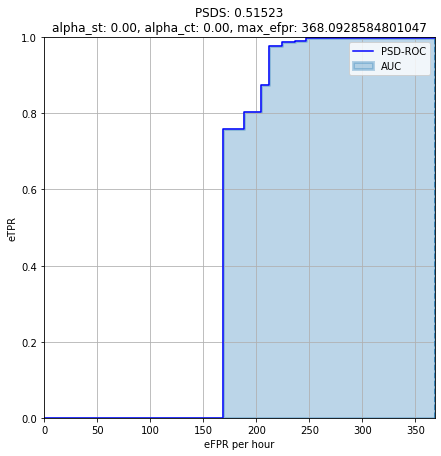

/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


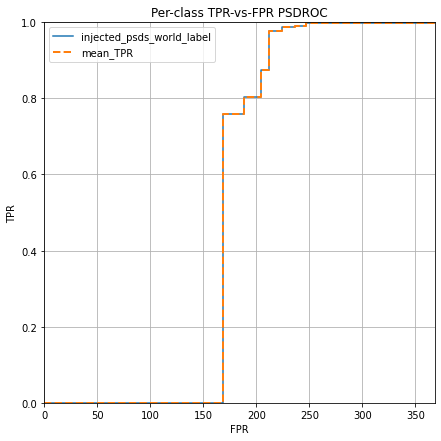

[  0.         169.01165051 188.71239505 204.0063941  212.04222411
 223.96635896 236.92737511 247.29618802 271.92211869 368.09285848]
[0.         0.75975716 0.80312229 0.87510841 0.97831743 0.98699046
 0.98959237 0.99739809 0.9991327  1.        ]
ROC 255.41936156485033
ROC norm 0.6938992585172788


In [94]:
do_eval('./data/predictions/dev/a', './data/labels/dev/a', filename = os.path.join(config.plot_dir, model_name + "_dev_a.png"))

In [ ]:
y_preds_all, y_test_A = evaluate_model(model, test_loader_A, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_A, filename = feat_type + '_' + model_name +'_Test_A')

In [ ]:
# Evaluate over dev B

In [100]:
# clear old predictions if necessary
!rm -rf ../data/predictions/dev/b
!mkdir ../data/predictions/dev/b

In [101]:
evaluate_model_timestamp('.wav','../data/audio/dev/b','../data/predictions/dev/b', 2, 
                         model_weights_path=f'../models/{model_name}.pth',
                         win_size=config.win_size, step_size=config.step_size, n_hop=config.n_hop, debug=False)

Evaluating model:


INFO:timm.models.helpers:Loading pretrained weights from url (https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth)
INFO:timm.models.helpers:Converted input conv stem.0 pretrained weights from 3 to 1 channel(s)


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0639 seconds
Loaded model: ../models/NoPCENmodel_e2_2022_06_14_18_14_22.pth
Processing: ../data/audio/dev/b for audio format: .wav
../data/audio/dev/b 222686.wav
dir_out ../data/predictions/dev/b filename 222686.wav
Processed: 222686.wav
../data/audio/dev/b 222713.wav
dir_out ../data/predictions/dev/b filename 222713.wav
Processed: 222713.wav
../data/audio/dev/b 222638.wav
Signal length too short, skipping: 0.399875 222638.wav
../data/audio/dev/b 199890.wav
dir_out ../data/predictions/dev/b filename 199890.wav
Processed: 199890.wav
../data/audio/dev/b 199929.wav
dir_out ../data/predictions/dev/b filename 199929.wav
Processed: 199929.wav
../data/audio/dev/b 222648.wav
dir_out ../data/predictions/dev/b filename 222648.wav
Processed: 222648.wav
../data/audio/dev/b 222659.wav
dir_out ../data/predictions/dev/b filename 222659.wav
Processed: 222659.wav
../

dir_out ../data/predictions/dev/b filename 199916.wav
Processed: 199916.wav
../data/audio/dev/b 199902.wav
dir_out ../data/predictions/dev/b filename 199902.wav
Processed: 199902.wav
../data/audio/dev/b 222707.wav
dir_out ../data/predictions/dev/b filename 222707.wav
Processed: 222707.wav
../data/audio/dev/b 222641.wav
dir_out ../data/predictions/dev/b filename 222641.wav
Processed: 222641.wav
../data/audio/dev/b 199913.wav
dir_out ../data/predictions/dev/b filename 199913.wav
Processed: 199913.wav
../data/audio/dev/b 199912.wav
dir_out ../data/predictions/dev/b filename 199912.wav
Processed: 199912.wav
../data/audio/dev/b 199942.wav
dir_out ../data/predictions/dev/b filename 199942.wav
Processed: 199942.wav
../data/audio/dev/b 199906.wav
dir_out ../data/predictions/dev/b filename 199906.wav
Processed: 199906.wav
../data/audio/dev/b 222665.wav
dir_out ../data/predictions/dev/b filename 222665.wav
Processed: 222665.wav
../data/audio/dev/b 222657.wav
dir_out ../data/predictions/dev/b fil

dir_out ../data/predictions/dev/b filename 222646.wav
Processed: 222646.wav
../data/audio/dev/b 222662.wav
dir_out ../data/predictions/dev/b filename 222662.wav
Processed: 222662.wav
Total files of .wav format processed: 157


debug [[ 69. 158.]
 [  0.   0.]] [0.97183099]

macro F-score: 46.31
debug [[ 68. 215.]
 [  0.   0.]] [0.95774648]

macro F-score: 38.42
debug [[ 64. 227.]
 [  0.   0.]] [0.90140845]

macro F-score: 35.36
debug [[ 62. 209.]
 [  0.   0.]] [0.87323944]

macro F-score: 36.26
debug [[ 56. 166.]
 [  0.   0.]] [0.78873239]

macro F-score: 38.23
debug [[ 52. 128.]
 [  0.   0.]] [0.73239437]

macro F-score: 41.43
debug [[45. 91.]
 [ 0.  0.]] [0.63380282]

macro F-score: 43.48
debug [[38. 50.]
 [ 0.  0.]] [0.53521127]

macro F-score: 47.80
debug [[27. 23.]
 [ 0.  0.]] [0.38028169]

macro F-score: 44.63
debug [[0. 0.]
 [0. 0.]] [0.]

macro F-score: nan

PSD-Score: 0.63740


/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:810: RuntimeWarning: invalid value encountered in true_divide
  num_gts = per_class_tp / tp_ratios
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:820: RuntimeWarning: Mean of empty slice
  f_avg = np.nanmean(f_per_class)
/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


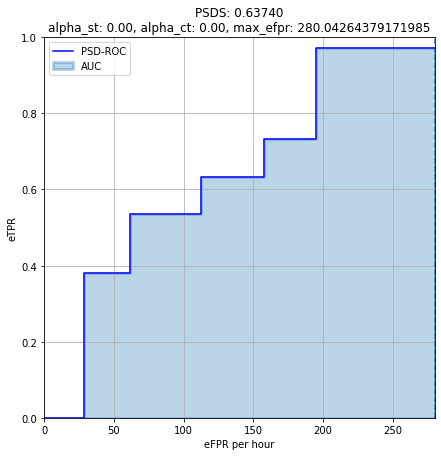

/my_data/UCB/W210/ComParE2022/src/psds_eval/psds.py:762: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(tpr_v_ctr.reshape([-1, ctr_points.size]), axis=0),
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


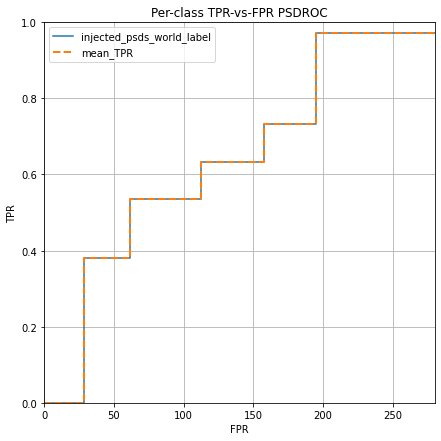

[  0.          28.37436479  61.68340172 112.26379112 157.90950839
 194.91954942 204.7888937  257.83661917 265.23862738 280.04264379]
[0.         0.38028169 0.53521127 0.63380282 0.73239437 0.97183099
 0.97183099 0.97183099 0.97183099 0.97183099]
ROC 195.64932488023612
ROC norm 0.6986411863249985


In [102]:
do_eval('./data/predictions/dev/b', './data/labels/dev/b', filename = os.path.join(config.plot_dir, model_name + "_dev_b.png"))

In [13]:
y_preds_all, y_test_B = evaluate_model(model, test_loader_B, 1, n_channels=1)  # Predict directly over feature windows (1.92 s)
PE, MI, log_prob = get_results(y_preds_all.numpy(), y_test_B, filename = feat_type + '_' + model_name +'_Test_B')

NameError: name 'evaluate_model' is not defined